<b><h1>Table of contents</h1><b>

<b><h2>1. Data import and high level exploration</h2><b>
<h4>1.1. Missing values cleaning</h4>
<h4>1.2. Text data cleaning and exploration</h4>
<h4>1.3. Time series data cleaning</h4>
<h4>1.4. Descriptive statistics & data visualization</h4>
<h5>1.4.1 Categorical variables</h5>
<h5>1.4.2 Numerical variables</h5>
    
<b><h2>2. In-depth analysis</h2><b>
<h4>2.1. Amount of sugar USA vs World</h4>
<h4>2.2. Nutrition score USA vs World</h4>   
<h4>2.3. Products from Palm oil USA vs World</h4>   
    
<b><h2>3. Time-series analysis</h2><b>

<b><h2>4. Build a database</h2><b>

<b><h2>5. Correlations with nutritional score</h2><b>




<b><h2>1. Data import and high level exploration</h2><b>

Here I see the warning "have mixed types..." This is because the data is too big to appropriately infer the dtype. I can fix it by defining each variable dtype or use low_memory=False. Here below I reload the data with low_memory=False. I also set a copy of the original dataframe 'df_clean'.

In [1]:
#data import

import numpy as np
import pandas as pd

df = pd.read_csv('en.openfoodfacts.org.products.tsv', sep='\t', low_memory=False)

#data copy
df_clean = df.copy()

In [2]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356027 entries, 0 to 356026
Columns: 163 entries, code to water-hardness_100g
dtypes: float64(107), object(56)
memory usage: 442.8+ MB


<h4>1.1. Missing values cleaning</h4>

First, I check the percentages in descending order of null values in the dataframe. Specifically, I look at the percentages because with this big data frame the sum of null values wouldn't be much informative. As arbitrary criteria I will remove the columns where missing values are above 50%, the idea is that I keep the "healthier" variables.

In [3]:
#missing values % for each variable
percent_missing_column = df_clean.isnull().sum().sort_values(ascending = False) * 100 / len(df_clean)

#with this part of code I temporarily set the number of rows that I want to display (#solution found here https://stackoverflow.com/questions/11707586/how-do-i-expand-the-output-display-to-see-more-columns-of-a-pandas-dataframe)
with pd.option_context('display.max_rows', None):
    print (percent_missing_column)

water-hardness_100g                           100.000000
no_nutriments                                 100.000000
-lignoceric-acid_100g                         100.000000
-cerotic-acid_100g                            100.000000
-melissic-acid_100g                           100.000000
glycemic-index_100g                           100.000000
-elaidic-acid_100g                            100.000000
-mead-acid_100g                               100.000000
-erucic-acid_100g                             100.000000
-nervonic-acid_100g                           100.000000
-caproic-acid_100g                            100.000000
-butyric-acid_100g                            100.000000
nutrition_grade_uk                            100.000000
ingredients_from_palm_oil                     100.000000
ingredients_that_may_be_from_palm_oil         100.000000
chlorophyl_100g                               100.000000
-palmitic-acid_100g                            99.999719
-stearic-acid_100g             

In [4]:
#remove the variables %null>50

null_values_50perc=len(df)/2
df_clean.dropna(thresh=null_values_50perc, axis=1, inplace=True)
df_clean.shape

(356027, 34)

To better explore the remaining null values I use a barplot where I plot the sum of missing values for each variable

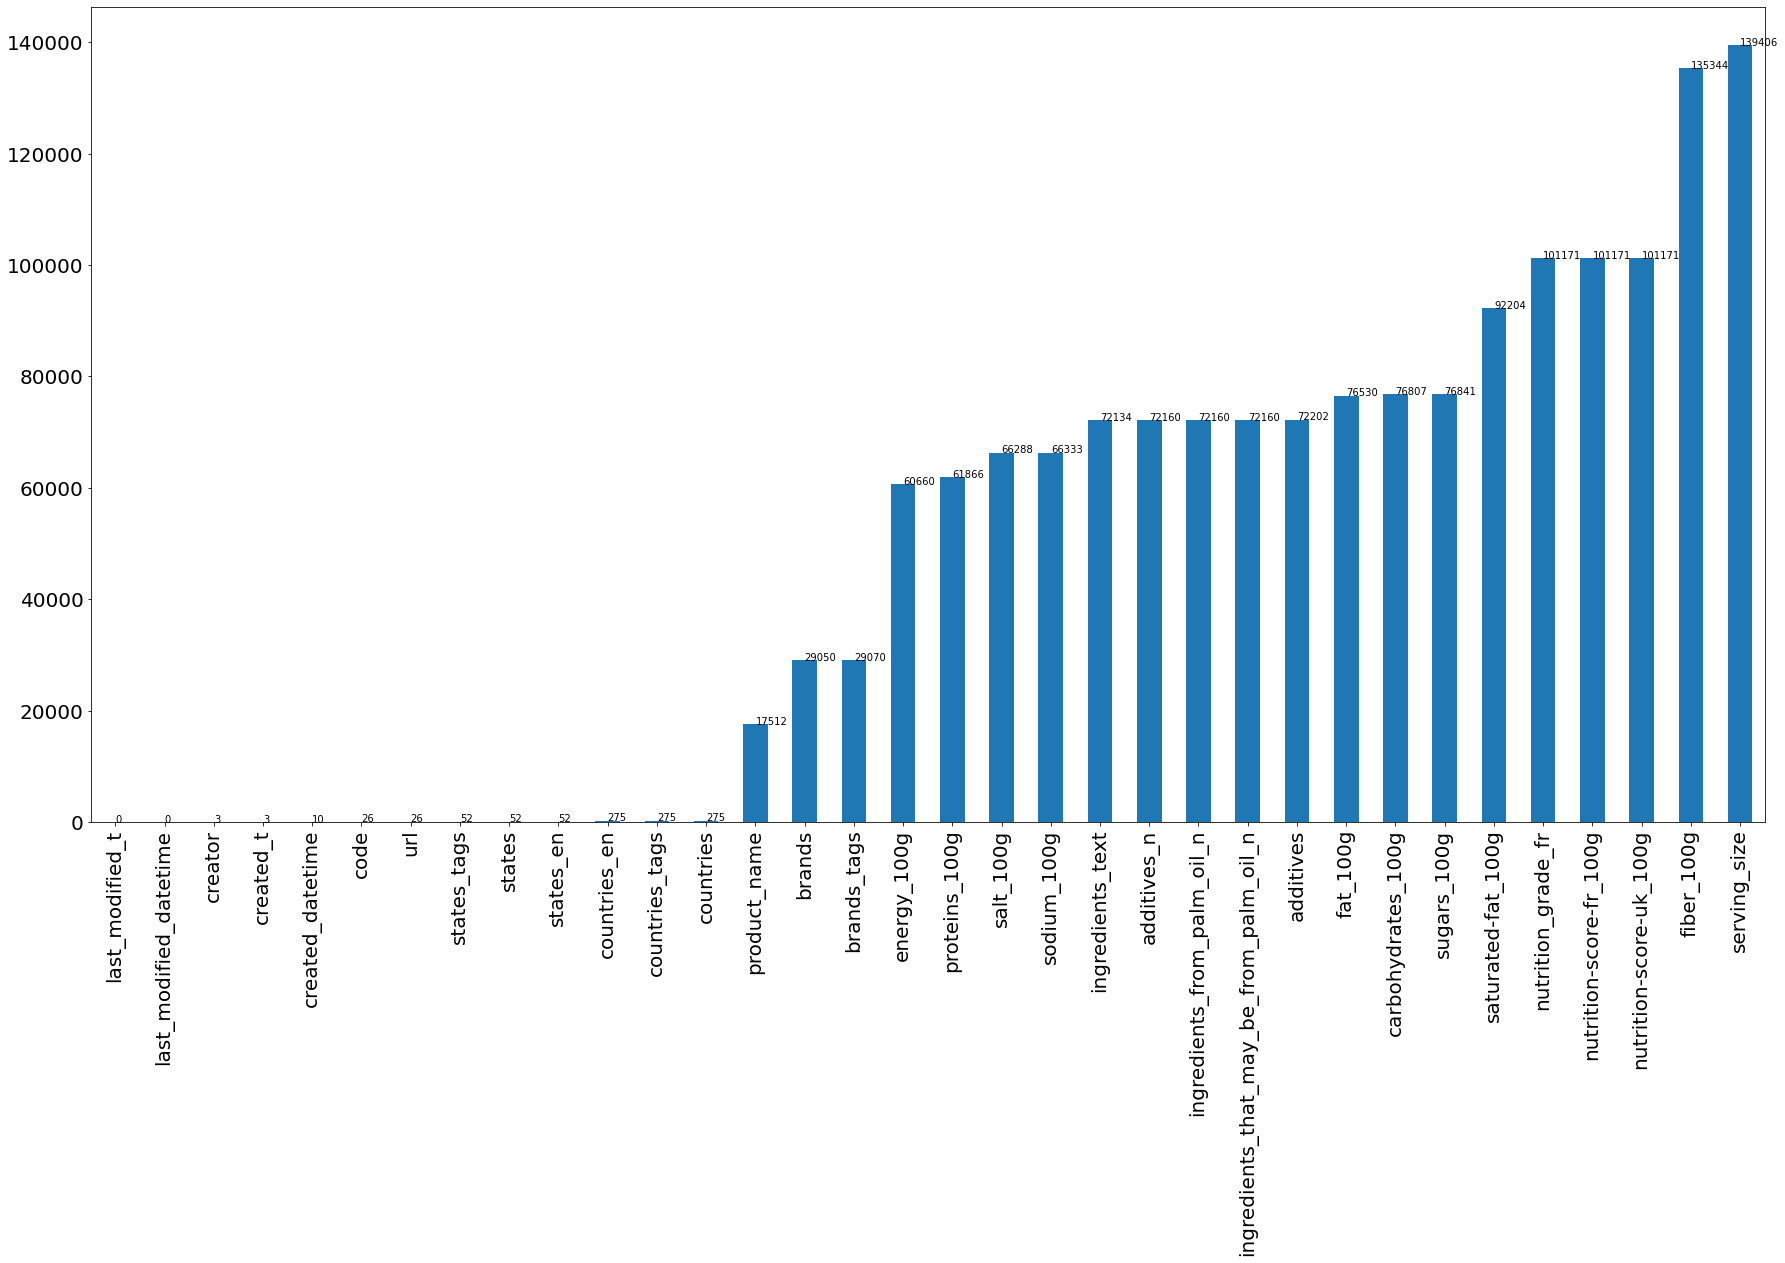

In [5]:
import matplotlib.pyplot as plt 
import seaborn as sns

#create a dataframe for the plot
plot_null=pd.DataFrame(df_clean.isnull().sum().sort_values(), columns=['null_sum'])

%matplotlib inline
ax=plot_null.plot.bar(figsize=(30,15),legend=False)
ax.tick_params(labelsize=20)
for i, v in plot_null.reset_index().iterrows():#add text on each column
    ax.text(i, v.null_sum + 0.2, v.null_sum)#solution found here https://stackoverflow.com/questions/42159250/how-to-show-the-count-values-on-the-top-of-a-bar-in-a-countplot
    
#double click to increase the plot size

In [6]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356027 entries, 0 to 356026
Data columns (total 34 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   code                                     356001 non-null  object 
 1   url                                      356001 non-null  object 
 2   creator                                  356024 non-null  object 
 3   created_t                                356024 non-null  object 
 4   created_datetime                         356017 non-null  object 
 5   last_modified_t                          356027 non-null  object 
 6   last_modified_datetime                   356027 non-null  object 
 7   product_name                             338515 non-null  object 
 8   brands                                   326977 non-null  object 
 9   brands_tags                              326957 non-null  object 
 10  countries                       

Now, I want to drop the missing values from the variables that are inferred as numeric (1- I want to leave the possibility to fully compare those variables 2- they should report a 0 rather than a null)

In [7]:
#dropna

df_clean.dropna(subset=['additives_n','ingredients_from_palm_oil_n','ingredients_that_may_be_from_palm_oil_n','energy_100g','fat_100g','saturated-fat_100g','carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition-score-fr_100g', 'nutrition-score-uk_100g'], inplace=True)
df_clean.shape

(190777, 34)

I check again the missing values plot

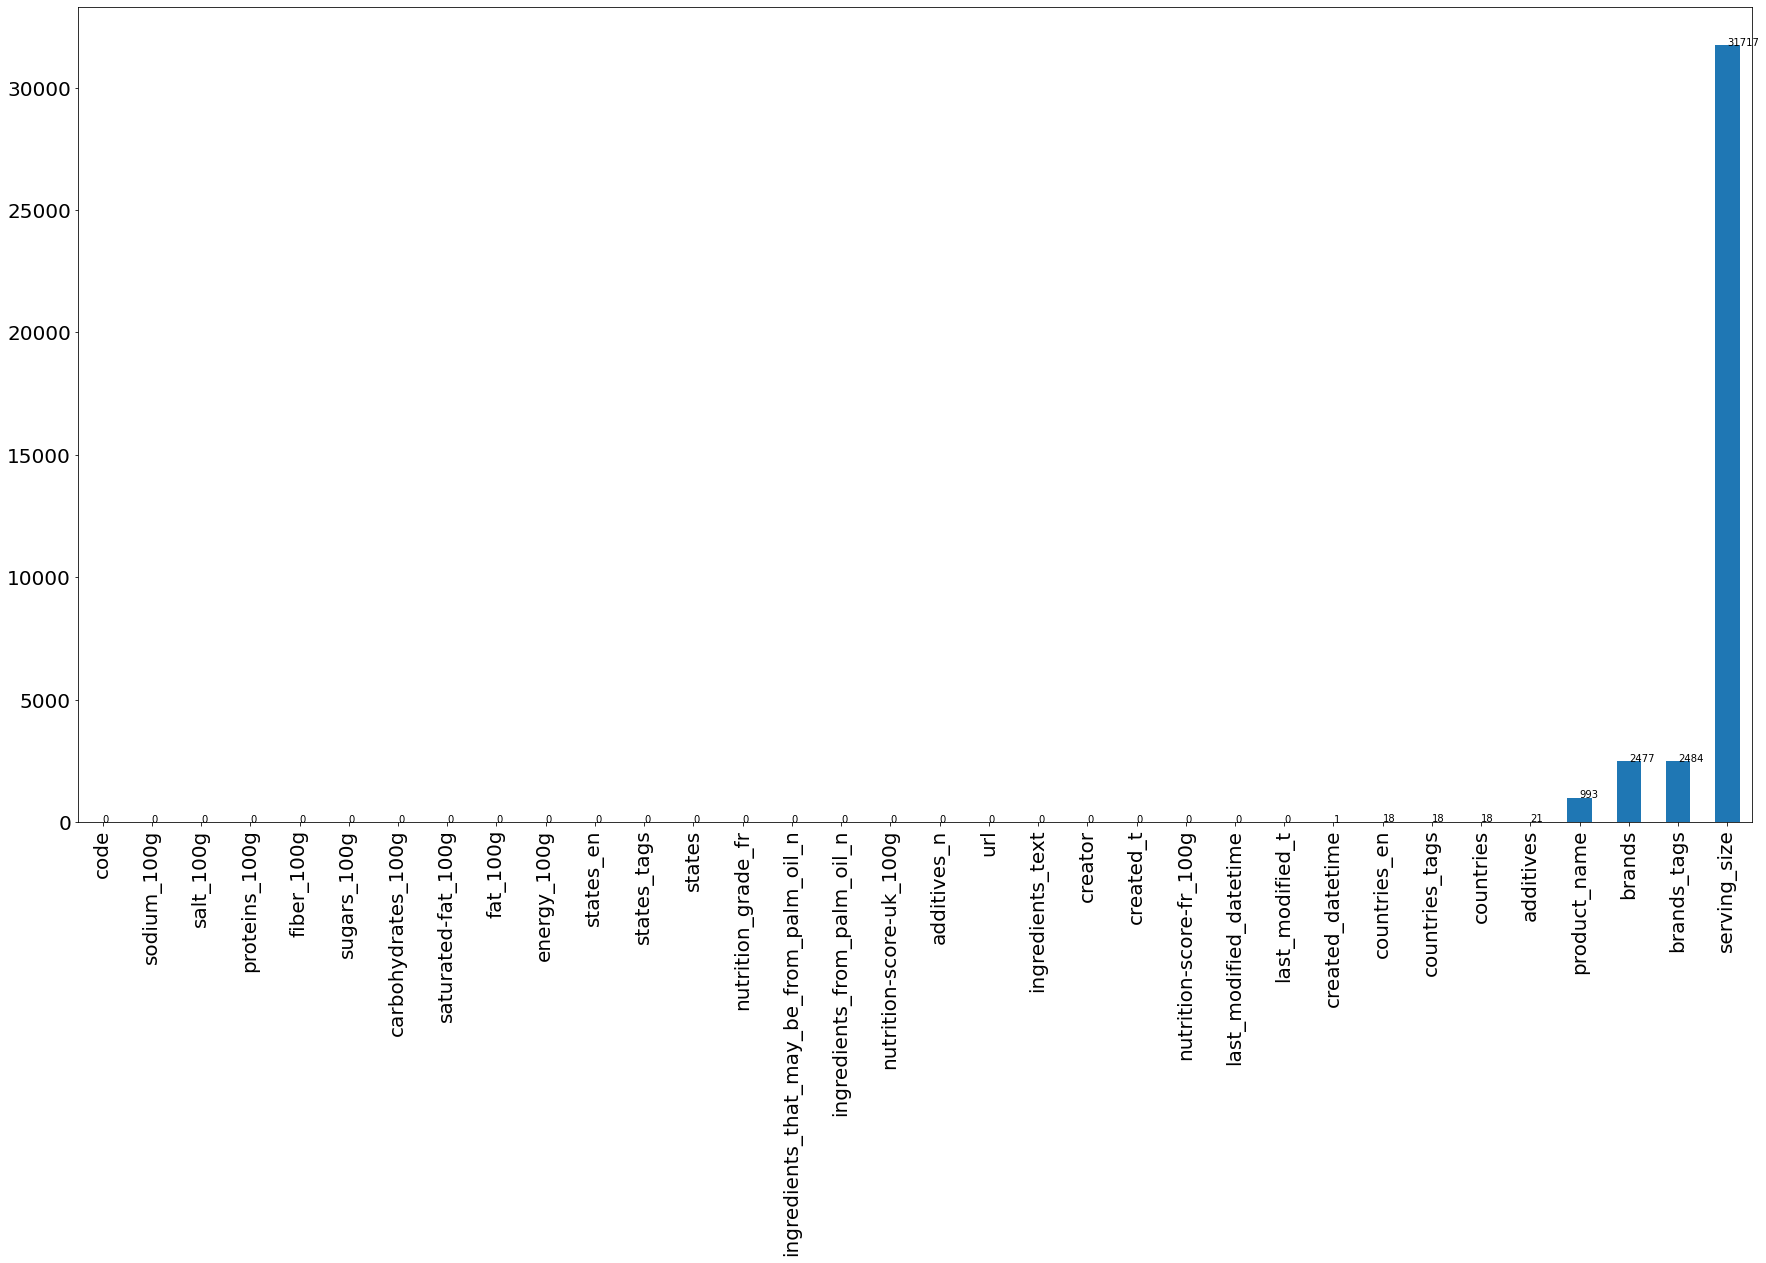

In [8]:
plot_null=pd.DataFrame(df_clean.isnull().sum().sort_values(), columns=['null_sum'])#create a dataframe for the plot

%matplotlib inline
ax=plot_null.plot.bar(figsize=(30,15),legend=False)
ax.tick_params(labelsize=20)
for i, v in plot_null.reset_index().iterrows():
    ax.text(i, v.null_sum + 0.2, v.null_sum)#solution found here https://stackoverflow.com/questions/42159250/how-to-show-the-count-values-on-the-top-of-a-bar-in-a-countplot
    #double click to increase the plot size

Most of the variables do not have null values. The one with more null values is 'serving_size'. Since is not really crucial for the following analysis that I intend to run I will fill the missing values as 'unknown' to save more data.

In [9]:
#fill na as 'unknown'

df_clean['serving_size'] = df_clean['serving_size'].fillna('unknown')
df_clean.shape

(190777, 34)

_______________________________
<h><h4>1.2. Text data cleaning and exploration</h4> 

Now I will manage the text data. 'brands' and 'brands_tags' probably containt similar information.
I first explore those variables.

In [10]:
df_clean[["brands", "brands_tags"]].head(10)

,brands,brands_tags
1,NaN,NaN
2,Torn & Glasser,torn-glasser
3,Grizzlies,grizzlies
7,Daddy's Muesli,daddy-s-muesli
12,Sunridge,sunridge
15,Grizzlies,grizzlies
16,Grizzlies,grizzlies
19,Pcc,pcc
20,Sunridge,sunridge
21,Sunridge,sunridge


In [11]:
#I turn brands ans brads_tags in lowercase

df_clean.brands = df_clean.brands.str.lower()
df_clean.brands_tags = df_clean.brands_tags.str.lower()

In [12]:
df_clean[['brands', 'brands_tags']].describe()

,brands,brands_tags
count,188300,188293
unique,34083,32129
top,carrefour,carrefour
freq,1898,1898


'brands_tags' has fewer unique values suggesting that the way the names are reported is more homogeneous. However, brands count is slightly higher than the brands_tags.
First, I will save the missing brand_tags values by filling the missing brands_tags with the brands value.
Second, I will drop the brands column

In [13]:
#fill na

df_clean['brands_tags'] = df_clean.brands_tags.fillna(df_clean.brands)
df_clean.drop('brands', axis=1, inplace=True)

Now I clean the brands_tags column from missing values

In [14]:
#drop na

df_clean.dropna(subset=['brands_tags'], inplace=True)
df_clean.shape

(188300, 33)

Now I check together 'countries_en', 'countries_tags' an 'countries' since they seems similar and have the same number of null values.

In [15]:
df_clean[['countries_en', 'countries_tags', 'countries']].head(10)

,countries_en,countries_tags,countries
2,United States,en:united-states,US
3,United States,en:united-states,US
7,United States,en:united-states,US
12,United States,en:united-states,US
15,United States,en:united-states,US
16,United States,en:united-states,US
19,United States,en:united-states,US
20,United States,en:united-states,US
21,United States,en:united-states,US
22,United States,en:united-states,US


In [16]:
#I turn all the variables in lowercase
df_clean.countries_en = df_clean.countries_en.str.lower()
df_clean.countries_tags = df_clean.countries_tags.str.lower()
df_clean.countries = df_clean.countries.str.lower()

In [17]:
df_clean[['countries_en','countries_tags','countries']].describe()

,countries_en,countries_tags,countries
count,188283,188283,188283
unique,375,375,699
top,united states,en:united-states,us
freq,133876,133876,132684


countries_en and countries_tags contain less unique values. Furthremore, the format of countries_en seems to be easier to handle.

I will continue using and cleaning only countries_en

In [18]:
#drop countries_tags and countries
df_clean.drop('countries_tags', axis=1, inplace=True)
df_clean.drop('countries', axis=1, inplace=True)

In [19]:
#check missing values in countries_en
df_clean.countries_en.isnull().sum()

17

Now I will remove the missing values in countries_en

In [20]:
#dropna
df_clean.dropna(subset=['countries_en'], inplace=True)

Now I check together with other 3 columns that might show similar information: check 'states', 'states_tags', 'states_en'

In [21]:
df_clean[['states', 'states_tags', 'states_en']].head(10)

,states,states_tags,states_en
2,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
3,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
7,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
12,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
15,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
16,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
19,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
20,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
21,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."
22,"en:to-be-completed, en:nutrition-facts-complet...","en:to-be-completed,en:nutrition-facts-complete...","To be completed,Nutrition facts completed,Ingr..."


states, states_tags and states_en contains some sort of metadata that I don't need for future analysis. I drop all the 3 columns.

In [22]:
#drop states, states_tags, states_en

df_clean.drop('states', axis=1, inplace=True)
df_clean.drop('states_tags', axis=1, inplace=True)
df_clean.drop('states_en', axis=1, inplace=True)

Let's check additives and ingredients_text because they might be similar

In [23]:
df_clean[['ingredients_text', 'additives']].head(10)

,ingredients_text,additives
2,"Peanuts, wheat flour, sugar, rice flour, tapio...",[ peanuts -> en:peanuts ] [ wheat-flour -> ...
3,"Organic hazelnuts, organic cashews, organic wa...",[ organic-hazelnuts -> en:organic-hazelnuts ...
7,"Org oats, org hemp granola (org oats, evaporat...",[ org-oats -> en:org-oats ] [ oats -> en:oa...
12,"Roasted peanuts (peanuts, peanut or canola oil...",[ roasted-peanuts -> en:roasted-peanuts ] [...
15,"Organic rolled oats, honey, raisins, almonds, ...",[ organic-rolled-oats -> en:organic-rolled-oa...
16,Organic raw hazelnuts.,[ organic-raw-hazelnuts -> en:organic-raw-haz...
19,Organic oat groats,[ organic-oat-groats -> en:organic-oat-groats...
20,"Yogurt raisins, tamari roasted almonds, organi...",[ yogurt-raisins -> en:yogurt-raisins ] [ r...
21,"Chocolate stars (dehydrated cane juice, sweete...",[ chocolate-stars -> en:chocolate-stars ] [...
22,"Organic rolled oats, organic evaporated cane j...",[ organic-rolled-oats -> en:organic-rolled-oa...


The content is similar but ingredients_text format easier to handle. I drop additives.

In [24]:
df_clean.drop('additives', axis=1, inplace=True)

In [25]:
#set ingredients_text to lowercase

df_clean.ingredients_text = df_clean.ingredients_text.str.lower()

In [26]:
#I drop the missing values from ingredients_text

df_clean.dropna(subset=['ingredients_text'],inplace=True)

Now I check product_name

In [27]:
df_clean[['product_name']].head(10)

,product_name
2,Peanuts
3,Organic Salted Nut Mix
7,Organic Muesli
12,Zen Party Mix
15,Cinnamon Nut Granola
16,Organic Hazelnuts
19,Organic Oat Groats
20,Energy Power Mix
21,Antioxidant Mix - Berries & Chocolate
22,Organic Quinoa Coconut Granola With Mango


Here I remove some duplicates that might contain the same product_name and brands_tags

In [28]:
# I drop all the column where brand_tags and product_name are the same and product_name missing values

df_clean.drop_duplicates(['product_name','brands_tags'],inplace=True)
df_clean.dropna(subset=['product_name'],inplace=True)

I check again the number of missing values in the df_clean

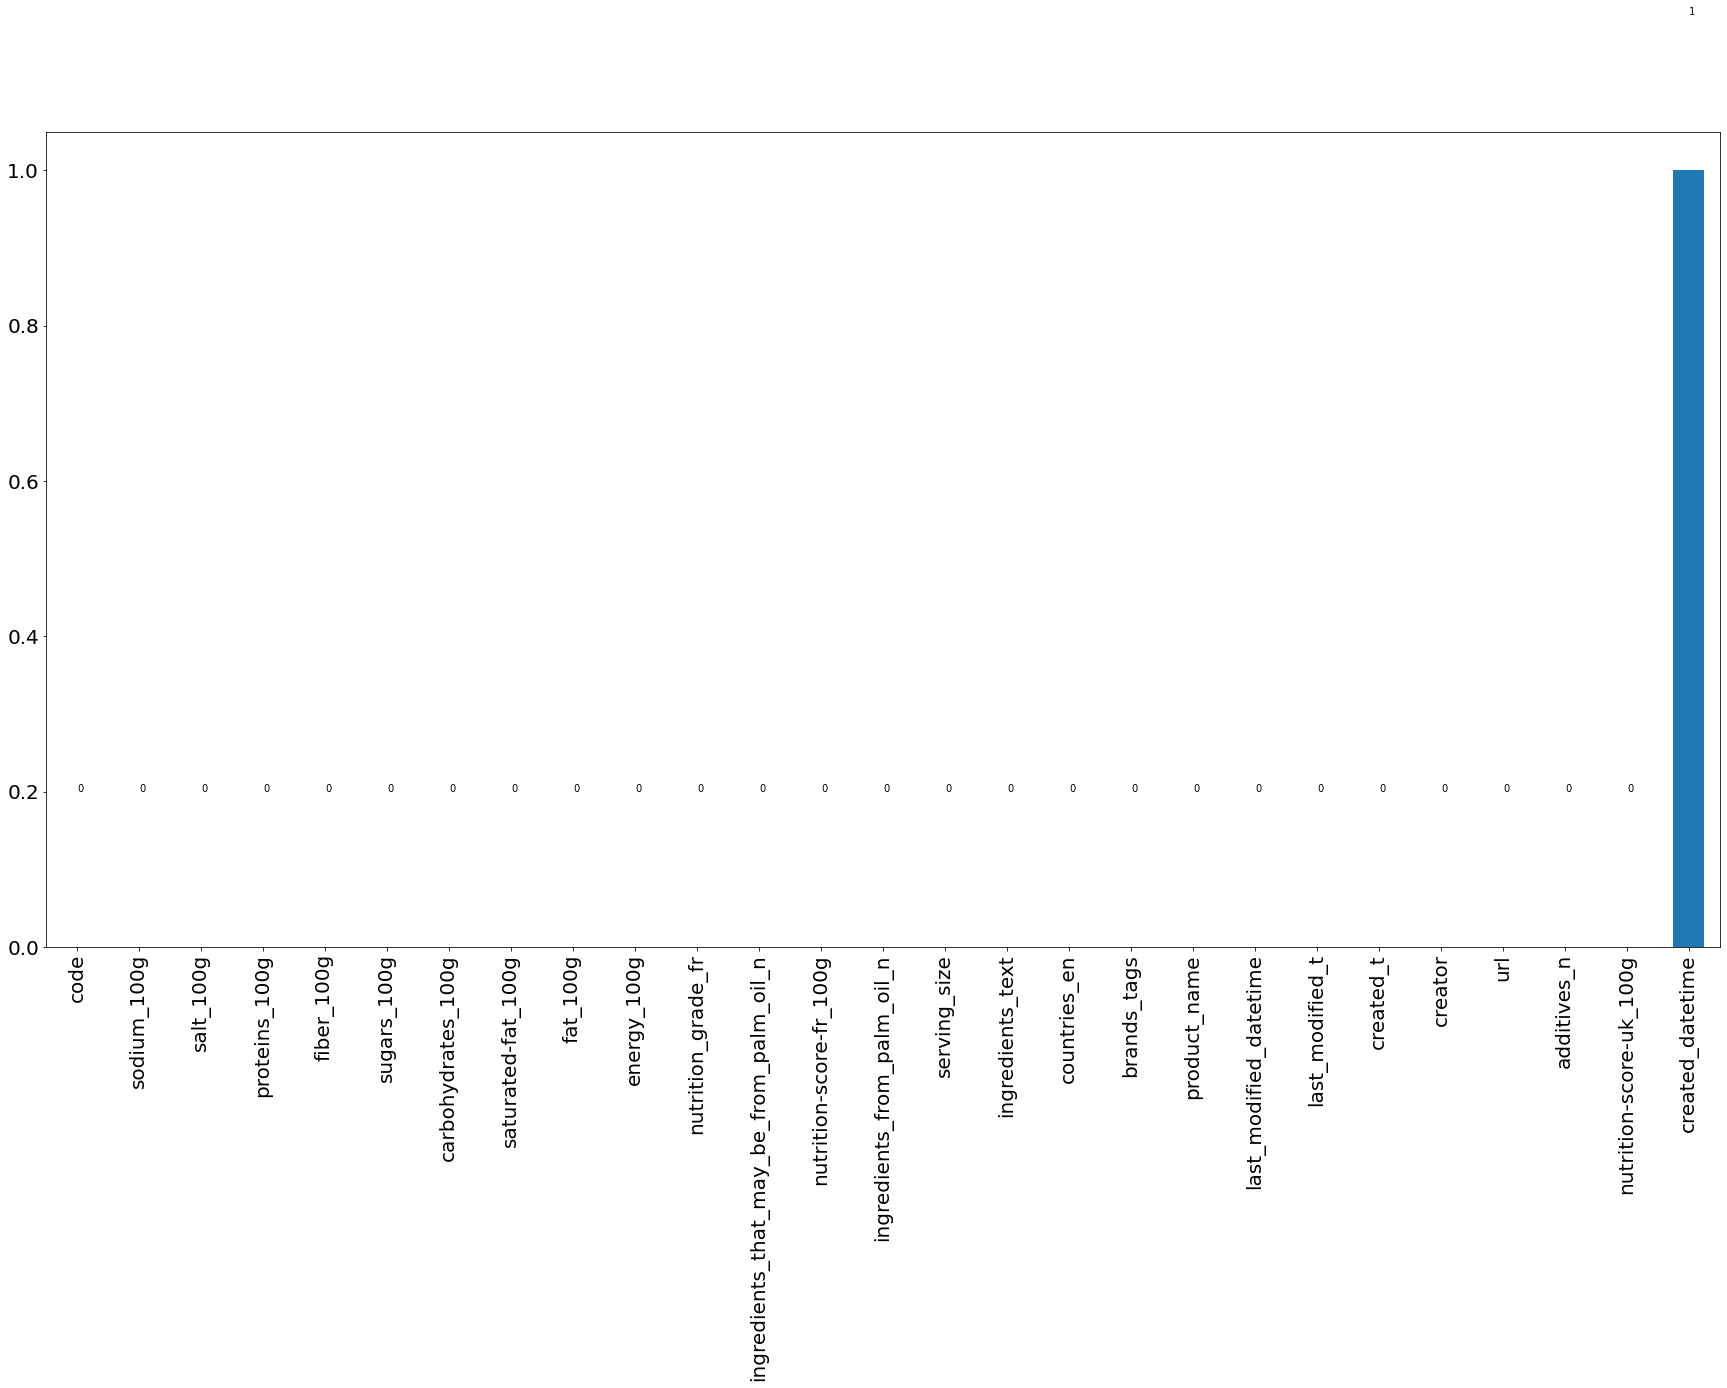

In [29]:
plot_null=pd.DataFrame(df_clean.isnull().sum().sort_values(), columns=['null_sum'])

%matplotlib inline
ax=plot_null.plot.bar(figsize=(30,15),legend=False)
ax.tick_params(labelsize=20)
for i, v in plot_null.reset_index().iterrows():
    ax.text(i, v.null_sum + 0.2, v.null_sum)

#double click to increase the plot size

In [30]:
#There is still 1 missing value in created_datetime, I remove it
df_clean.dropna(subset=['created_datetime'],inplace=True)

In [31]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175388 entries, 2 to 356022
Data columns (total 27 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   code                                     175388 non-null  object 
 1   url                                      175388 non-null  object 
 2   creator                                  175388 non-null  object 
 3   created_t                                175388 non-null  object 
 4   created_datetime                         175388 non-null  object 
 5   last_modified_t                          175388 non-null  object 
 6   last_modified_datetime                   175388 non-null  object 
 7   product_name                             175388 non-null  object 
 8   brands_tags                              175388 non-null  object 
 9   countries_en                             175388 non-null  object 
 10  ingredients_text                

In [32]:
df_clean.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
count,175388.000000,175388.000000,175388.000000,175388.000000,175388.000000,175388.000000,175388.000000,175388.000000,1.753880e+05,175388.000000,175388.000000,175388.000000,175388.000000,175388.000000
mean,1.913517,0.021638,0.055448,1184.717173,12.977194,4.614470,34.277174,14.792416,4.836058e+05,7.708962,1.353609,0.532917,8.662731,8.516586
std,2.536540,0.147367,0.268837,761.016927,15.802205,7.081086,28.224702,19.344396,2.025298e+08,8.055393,12.836922,5.053905,9.038453,9.120182
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-17.860000,0.000000e+00,0.000000,0.000000,0.000000,-15.000000,-15.000000
25%,0.000000,0.000000,0.000000,453.000000,0.830000,0.000000,7.860000,1.410000,0.000000e+00,2.000000,0.100000,0.039370,1.000000,1.000000
50%,1.000000,0.000000,0.000000,1205.000000,6.900000,1.600000,26.000000,5.100000,1.600000e+00,5.700000,0.640080,0.252000,9.000000,9.000000
75%,3.000000,0.000000,0.000000,1736.000000,21.050000,6.670000,60.000000,23.000000,3.600000e+00,10.710000,1.330960,0.524000,16.000000,16.000000
max,30.000000,2.000000,6.000000,14644.000000,100.000000,100.000000,165.000000,104.000000,8.481815e+10,305.000000,2452.413180,965.517000,40.000000,40.000000


In [33]:
df_clean.shape

(175388, 27)

_____________________
Here I will further clean the text data columns. In particular, I'm interested in countries_en and ingredients_text.

I start with countries_en

In [34]:
#here I check the list of brands to see what are the possible issues
x= pd.DataFrame(df_clean.countries_en.value_counts())
with pd.option_context('display.max_rows', None):
    print(x)

                                                    countries_en
united states                                             122587
france                                                     40825
switzerland                                                 3294
spain                                                       1606
germany                                                     1442
united kingdom                                              1100
france,switzerland                                           698
belgium,france                                               382
belgium                                                      287
italy                                                        232
france,united kingdom                                        230
portugal                                                     218
canada                                                       151
france,united states                                         142
france,spain             

In [35]:
#I noticed that the is one series of county with a different format (france,fr:frankrijk,fr:griekenland,fr:spanje). I will clean this.
df_clean['countries_en'] = df_clean['countries_en'].str.replace('fr:','')#remove 'fr:'
df_clean['countries_en'] = df_clean['countries_en'].str.replace('nl:','')#remove 'fr:'
df_clean['countries_en'] = df_clean['countries_en'].str.replace('other-日本','')
df_clean['countries_en'] = df_clean['countries_en'].str.replace('日本','japan')#日本 is japan
df_clean['countries_en'] = df_clean['countries_en'].str.replace('香港 ','hong kong')#香港  is hong kong
df_clean['countries_en'] = df_clean['countries_en'].str.replace(',frankrijk','')# frankrijk is france. On the same rows france is already reported
df_clean['countries_en'] = df_clean['countries_en'].str.replace(',deutschland','')# deutschland is germany. On the same rows france is already reported
df_clean['countries_en'] = df_clean['countries_en'].str.replace('griekenland','greece')#griekenland is greece
df_clean['countries_en'] = df_clean['countries_en'].str.replace('spanje','spain')#spanje is spain
df_clean['countries_en'] = df_clean['countries_en'].str.replace('frankreich','france')#frankreich is france

Now I check the count of the different countries and I apply a second correction if needed

In [36]:
#here I use the stack function to create a sum of the the countries since more country are reported on the same row

#I use str.split + stack to vectorize the countries
x = pd.DataFrame(df_clean.countries_en.str.split(',', expand=True).stack().value_counts())
with pd.option_context('display.max_rows', None):
    print(x)

                                      0
united states                    122825
france                            43227
switzerland                        4330
spain                              1850
germany                            1785
united kingdom                     1441
belgium                             844
italy                               315
portugal                            293
netherlands                         209
canada                              189
australia                           161
sweden                              140
serbia                              118
mexico                               81
guadeloupe                           79
austria                              62
denmark                              60
réunion                              47
romania                              40
new zealand                          38
french guiana                        36
luxembourg                           36
martinique                           24


In [37]:
df_clean['countries_en'] = df_clean['countries_en'].str.replace('nederland:','netherlands')
df_clean['countries_en'] = df_clean['countries_en'].str.replace('schweiz','switzerland')
df_clean['countries_en'] = df_clean['countries_en'].str.replace('allemagne','germany')
df_clean['countries_en'] = df_clean['countries_en'].str.replace('spanien','germany')
df_clean['countries_en'] = df_clean['countries_en'].str.replace('香港','hong kong')
df_clean['countries_en'] = df_clean['countries_en'].str.replace('marseille-5','france')
df_clean['countries_en'] = df_clean['countries_en'].str.replace('szczecin','poland')#szczecin is a city
df_clean['countries_en'] = df_clean['countries_en'].str.replace('angleterre','united kingdom')#there is no england
df_clean['countries_en'] = df_clean['countries_en'].str.replace('bourgogne-aube-nogent-sur-seine','france')
df_clean['countries_en'] = df_clean['countries_en'].str.replace('szczecin','germany')
df_clean['countries_en'] = df_clean['countries_en'].str.replace('turquie','turkey')
df_clean['countries_en'] = df_clean['countries_en'].str.replace('szczegrande-bretagne','united kingdom')
df_clean['countries_en'] = df_clean['countries_en'].str.replace('other-turkey','turkey')

___________
Now I will check the ingredients_text with the same strategy as above. However, I will not go very deep and I will check only the first 50 ingredients

In [38]:
#I use str.split + stack to vectorize the ingredients
x=pd.DataFrame(df_clean.ingredients_text.str.split(',', expand=True).stack().value_counts().head(50))
with pd.option_context('display.max_rows', None):
    print(x)

                               0
 salt                      67405
 sugar                     42124
 water                     37851
 sel                       20167
 niacin                    17473
 riboflavin                15643
 sucre                     14490
 citric acid               14092
 folic acid)               12662
 eau                       12639
 dextrose                  12193
 reduced iron              11919
 corn syrup                11827
 thiamine mononitrate      10003
 sea salt                   9115
 spices                     9015
 soybean oil                8313
 natural flavor             8104
 soy lecithin               7760
sugar                       7662
 cocoa butter               7383
water                       6608
 salt)                      6598
 xanthan gum                6368
 maltodextrin               6172
 high fructose corn syrup   6157
 garlic                     6119
 whey                       5987
 yeast                      5926
 vinegar  

In [39]:
# some values are shifted on the left, suggesting that sometimes ingredients are separated by the following pattern ", ". I will change it to ","

In [40]:
df_clean['ingredients_text'] = df_clean['ingredients_text'].str.replace(', ',',')

In [41]:
#I see that the same ingredients are reported in different languages/format
df_clean['ingredients_text'] = df_clean['ingredients_text'].str.replace('sel','salt')
df_clean['ingredients_text'] = df_clean['ingredients_text'].str.replace('.','')#see 'salt.'
df_clean['ingredients_text'] = df_clean['ingredients_text'].str.replace('sucre','sugar')
df_clean['ingredients_text'] = df_clean['ingredients_text'].str.replace('eau','water')
df_clean['ingredients_text'] = df_clean['ingredients_text'].str.replace(')','')#see 'salt)' and 'folic acid)'
df_clean['ingredients_text'] = df_clean['ingredients_text'].str.replace('huile de tournesol','sunflower oil')

Let's check if the 10 first entries are good

In [42]:
pd.DataFrame(df_clean.ingredients_text.str.split(',', expand=True).stack().value_counts().head(10))

,0
salt,103008
sugar,68069
water,61938
citric acid,18520
niacin,17521
riboflavin,15814
folic acid,15700
corn syrup,13516
dextrose,12888
sea salt,12294


______________
<h4>1.3. Time series data cleaning</h4>

the columns that may contain datetime are created_datetime, created_t, last_modified_t, last_modified_datetime.

In [43]:
df_clean[['created_datetime', 'created_t', 'last_modified_t', 'last_modified_datetime']]

,created_datetime,created_t,last_modified_t,last_modified_datetime
2,2017-03-09T14:32:37Z,1489069957,1489069957,2017-03-09T14:32:37Z
3,2017-03-09T10:35:31Z,1489055731,1489055731,2017-03-09T10:35:31Z
7,2017-03-09T10:35:11Z,1489055711,1489055712,2017-03-09T10:35:12Z
12,2017-03-09T10:34:10Z,1489055650,1489055651,2017-03-09T10:34:11Z
15,2017-03-09T10:34:12Z,1489055652,1489055653,2017-03-09T10:34:13Z
...,...,...,...,...
355979,2017-08-26T11:08:12Z,1503745692,1503745703,2017-08-26T11:08:23Z
355980,2017-07-09T16:26:31Z,1499617591,1499617638,2017-07-09T16:27:18Z
355981,2017-07-24T17:31:16Z,1500917476,1500917479,2017-07-24T17:31:19Z
355985,2017-03-09T20:45:00Z,1489092300,1489092300,2017-03-09T20:45:00Z


the most suitable columns to be a datetime are created_datetime and last_modified_datetime

In [44]:
df_clean.drop('created_t', axis=1, inplace=True)
df_clean.drop('last_modified_t', axis=1, inplace=True)

In [45]:
#If I try to convert those variable to datetime I get some errors (pd.to_datetime(df.created_datetime)).
#I will force the errors using coerce and then I check if NaT are created with isna https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.isna.html
df_clean['created_datetime'] = pd.to_datetime(df_clean['created_datetime'], errors='coerce', format='%Y-%m-%dT%H:%M:%SZ')# solution found here https://stackoverflow.com/questions/53537443/unknown-string-format-on-pd-to-datetime

In [46]:
#same for last_modified_datetime
df_clean['last_modified_datetime'] = pd.to_datetime(df_clean['last_modified_datetime'], errors='coerce', format='%Y-%m-%dT%H:%M:%SZ')

In [47]:
#check if coerce created some NaT
df_clean['created_datetime'].isna().sum()

0

In [48]:
#check if coerce created some NaT
df_clean['last_modified_datetime'].isna().sum()

0

In [49]:
#create a time delta of the difference between last_modified_datetime and created_datetime
df_clean['delta_time']=df_clean['last_modified_datetime']-df_clean['created_datetime']

In [50]:
df_clean['delta_time'].head(10)

2    00:00:00
3    00:00:00
7    00:00:01
12   00:00:01
15   00:00:01
16   00:00:00
19   00:00:00
20   00:00:00
21   00:00:01
22   00:00:00
Name: delta_time, dtype: timedelta64[ns]

In [51]:
#double-check if there are negative differences between the 2 datetimes (it shouldn't)
x=pd.DataFrame(df_clean['last_modified_datetime'] < df_clean['created_datetime'],columns=['difference'])
x['difference'].value_counts()

False    175388
Name: difference, dtype: int64

In [52]:
df_clean.shape

(175388, 26)

____________
<h4>1.4. Descriptive statistics & data visualization</h4>

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [54]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175388 entries, 2 to 356022
Data columns (total 26 columns):
 #   Column                                   Non-Null Count   Dtype          
---  ------                                   --------------   -----          
 0   code                                     175388 non-null  object         
 1   url                                      175388 non-null  object         
 2   creator                                  175388 non-null  object         
 3   created_datetime                         175388 non-null  datetime64[ns] 
 4   last_modified_datetime                   175388 non-null  datetime64[ns] 
 5   product_name                             175388 non-null  object         
 6   brands_tags                              175388 non-null  object         
 7   countries_en                             175388 non-null  object         
 8   ingredients_text                         175388 non-null  object         
 9   serving_size   

________________

<b>1.4.1 Categorical variables<b>

__________________
<b>Brands Plot<b>

In [55]:
#create a df for the plot based on the brands sum.Columns are 'Brands' and 'Count'
brands_tags_plot=pd.DataFrame(df_clean.brands_tags.value_counts())

#the only column is now 'brands_tags'
brands_tags_plot.reset_index(inplace=True)

#rename the indec in Brands and 'brands_tags' in Counts (this is just to not change the axis names afterwards)
brands_tags_plot.rename(columns = {'index':'Brands', 'brands_tags' : 'Count'}, inplace = True)

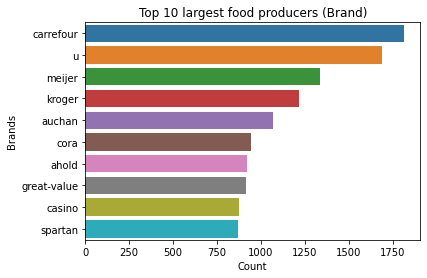

In [56]:
#plot the first the top 10 brands
brands_tags_plot= brands_tags_plot.sort_values('Count', ascending = False).iloc[0:10, :]
sns.barplot(x="Count", y="Brands", data=brands_tags_plot).set_title('Top 10 largest food producers (Brand)');

________________
<b>Countries Plot</b>

In [57]:
#I use str.split and stack to vectorize the dataframe
countries_plot=pd.DataFrame(df_clean.countries_en.str.split(',', expand=True).stack().value_counts().head(10))

In [58]:
#I rename the columns
countries_plot.reset_index(inplace=True)
countries_plot.rename(columns = {'index':'Countries', 0 : 'Count'}, inplace = True) #by default the result of value_counts name the column 0

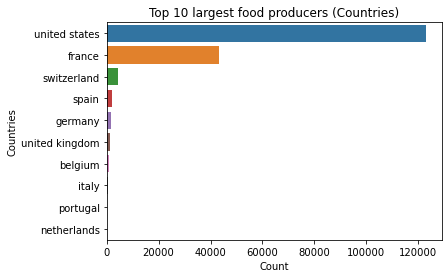

In [59]:
#plot
sns.barplot(x="Count", y="Countries", data=countries_plot).set_title('Top 10 largest food producers (Countries)');

__________
<b>Ingredients plot</b>

In [60]:
#I use str.split + stack to vectorize the ingredients
ingredients_plot=pd.DataFrame(df_clean.ingredients_text.str.split(',', expand=True).stack().value_counts().head(10))

In [61]:
#I rename the columns
ingredients_plot.reset_index(inplace=True)
ingredients_plot.rename(columns = {'index':'Ingredients', 0 : 'Count'}, inplace = True) #by default the result of value_counts name the column 0

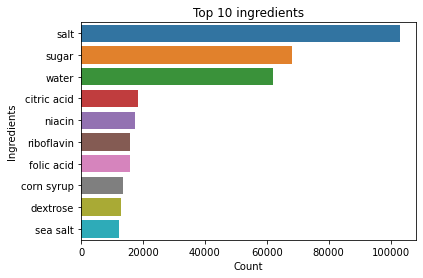

In [62]:
#plot
sns.barplot(x="Count", y="Ingredients", data=ingredients_plot).set_title('Top 10 ingredients');

<b>Nutrition grad (fr) plot</b>

Here I will use a pie chart with percentages

In [63]:
#compute percentages
nutrition_grade_fr_plot=pd.DataFrame(df_clean.nutrition_grade_fr.value_counts()*100 / len(df_clean))

In [64]:
#rename variables  and sort
nutrition_grade_fr_plot.reset_index(inplace=True)
nutrition_grade_fr_plot.rename(columns = {'index':'Nutrition_grade_fr', 'nutrition_grade_fr':'Percentage'}, inplace = True)
nutrition_grade_fr_plot.sort_values('Nutrition_grade_fr')

,Nutrition_grade_fr,Percentage
3,a,18.054257
4,b,15.591146
1,c,20.955253
0,d,27.075969
2,e,18.323374


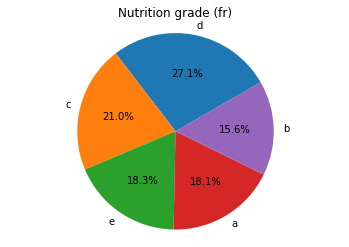

In [65]:
#pie chart, solution found here https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html#sphx-glr-gallery-pie-and-polar-charts-pie-features-py
fig1, ax1 = plt.subplots()
ax1.pie(nutrition_grade_fr_plot.Percentage, labels=nutrition_grade_fr_plot.Nutrition_grade_fr, autopct='%1.1f%%', startangle=30)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
ax1.set_title("Nutrition grade (fr)")
plt.show()

___________

<b>1.4.2 Numerical variables<b>

_________________
Here below, for each numerical variable I will display:

-descriptive stats

-amount of outliers (based on the IQR)

-distribution plot + boxplot
_____________________________________________________

<b>additives_n<b>

count    175388.000000
mean          1.913517
std           2.536540
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          30.000000
Name: additives_n, dtype: float64
Total number of outliers detected: 7099
% of outliers: 4.048


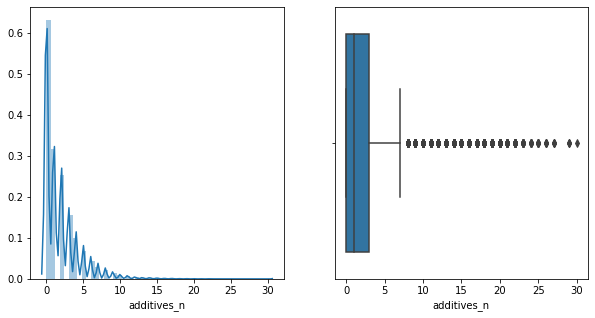

In [66]:
print(df_clean.additives_n.describe())

#outliers
additives_n=df_clean['additives_n'].to_numpy()
Q1 = np.percentile(additives_n, 25, axis=0)
Q3 = np.percentile(additives_n, 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

boxplot_filter = (additives_n < lower_bound) | (additives_n > upper_bound)
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())
percentage_outliers=boxplot_filter.sum(axis=0)* 100 / len(additives_n)
print("% of outliers:", round(percentage_outliers, 3))

#figure
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.distplot(df_clean.additives_n, ax=ax1)
sns.boxplot(df_clean.additives_n, ax=ax2);

________________________________
<b>ingredients_from_palm_oil_n<b>

count    175388.000000
mean          0.021638
std           0.147367
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           2.000000
Name: ingredients_from_palm_oil_n, dtype: float64
Total number of outliers detected: 3747
% of outliers: 2.136


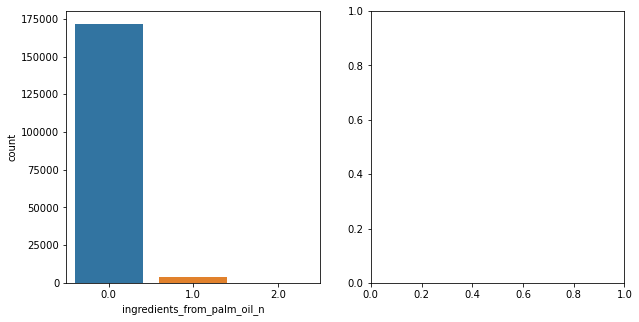

In [67]:
print(df_clean.ingredients_from_palm_oil_n.describe())

#outliers
ingredients_from_palm_oil_n=df_clean['ingredients_from_palm_oil_n'].to_numpy()
Q1 = np.percentile(ingredients_from_palm_oil_n, 25, axis=0)
Q3 = np.percentile(ingredients_from_palm_oil_n, 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

boxplot_filter = (ingredients_from_palm_oil_n < lower_bound) | (ingredients_from_palm_oil_n > upper_bound)
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())
percentage_outliers=boxplot_filter.sum(axis=0)* 100 / len(additives_n)
print("% of outliers:", round(percentage_outliers, 3))


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.countplot(df_clean.ingredients_from_palm_oil_n, ax=ax1); #here I use the countplot because this variable is not really suitable for a distribution plot. The boxplot is not informative.

__________________________
<b>ingredients_that_may_be_from_palm_oil_n<b>

count    175388.000000
mean          0.055448
std           0.268837
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           6.000000
Name: ingredients_that_may_be_from_palm_oil_n, dtype: float64
Total number of outliers detected: 8289
% of outliers: 4.726


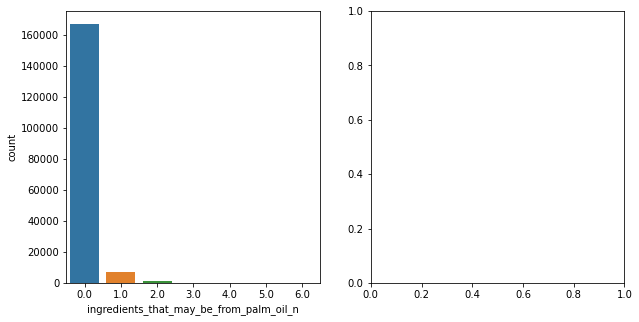

In [68]:
print(df_clean.ingredients_that_may_be_from_palm_oil_n.describe())

#outliers
ingredients_that_may_be_from_palm_oil_n=df_clean['ingredients_that_may_be_from_palm_oil_n'].to_numpy()
Q1 = np.percentile(ingredients_that_may_be_from_palm_oil_n, 25, axis=0)
Q3 = np.percentile(ingredients_that_may_be_from_palm_oil_n, 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

boxplot_filter = (ingredients_that_may_be_from_palm_oil_n < lower_bound) | (ingredients_that_may_be_from_palm_oil_n > upper_bound)
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())
percentage_outliers=boxplot_filter.sum(axis=0)* 100 / len(additives_n)
print("% of outliers:", round(percentage_outliers, 3))


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.countplot(df_clean.ingredients_that_may_be_from_palm_oil_n, ax=ax1); #here I use the countplot because this variable is not really suitable for a distribution plot. The boxplot is not informative.

______________________________
<b>energy_100g<b>

count    175388.000000
mean       1184.717173
std         761.016927
min           0.000000
25%         453.000000
50%        1205.000000
75%        1736.000000
max       14644.000000
Name: energy_100g, dtype: float64
Total number of outliers detected: 446
% of outliers: 0.254


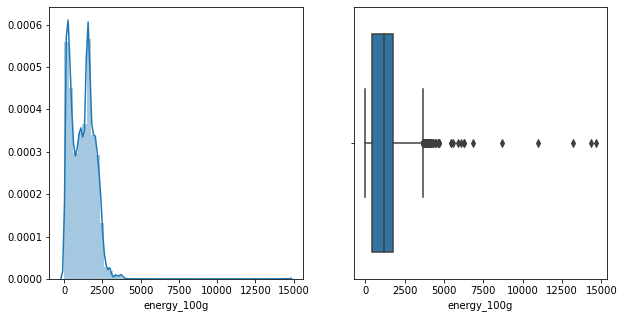

In [69]:
print(df_clean.energy_100g.describe())

#outliers
energy_100g=df_clean['energy_100g'].to_numpy()
Q1 = np.percentile(energy_100g, 25, axis=0)
Q3 = np.percentile(energy_100g, 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

boxplot_filter = (energy_100g < lower_bound) | (energy_100g > upper_bound)
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())
percentage_outliers=boxplot_filter.sum(axis=0)* 100 / len(additives_n)
print("% of outliers:", round(percentage_outliers, 3))


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.distplot(df_clean.energy_100g, ax=ax1)
sns.boxplot(df_clean.energy_100g, ax=ax2);

_______________________
<b>fat_100g<b>

count    175388.000000
mean         12.977194
std          15.802205
min           0.000000
25%           0.830000
50%           6.900000
75%          21.050000
max         100.000000
Name: fat_100g, dtype: float64
Total number of outliers detected: 4497
% of outliers: 2.564


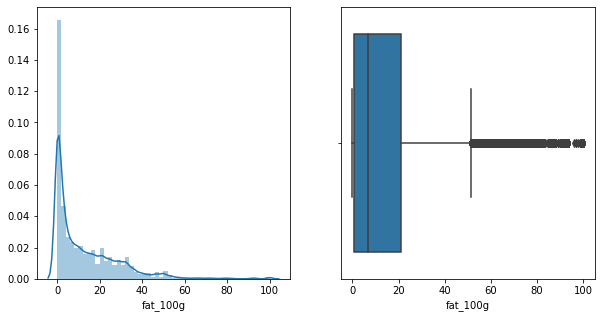

In [70]:
print(df_clean.fat_100g.describe())

#outliers
fat_100g=df_clean['fat_100g'].to_numpy()
Q1 = np.percentile(fat_100g, 25, axis=0)
Q3 = np.percentile(fat_100g, 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

boxplot_filter = (fat_100g < lower_bound) | (fat_100g > upper_bound)
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())
percentage_outliers=boxplot_filter.sum(axis=0)* 100 / len(additives_n)
print("% of outliers:", round(percentage_outliers, 3))


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.distplot(df_clean.fat_100g, ax=ax1)
sns.boxplot(df_clean.fat_100g, ax=ax2);

_________________
<b>saturated-fat_100g<b>

count    175388.000000
mean          4.614470
std           7.081086
min           0.000000
25%           0.000000
50%           1.600000
75%           6.670000
max         100.000000
Name: saturated_fat_100g, dtype: float64
Total number of outliers detected: 12635
% of outliers: 7.204


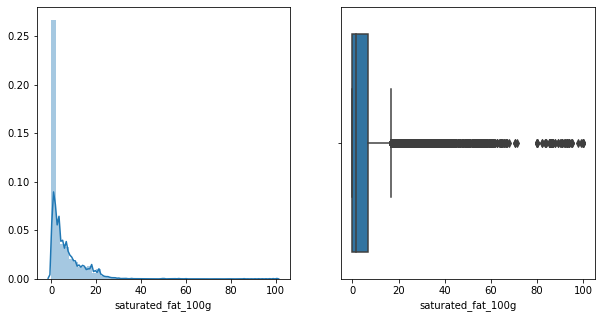

In [71]:
#this column has to be renamed first replacing '-' with '_'
df_clean.rename(columns = {'saturated-fat_100g':'saturated_fat_100g'}, inplace = True)

print(df_clean.saturated_fat_100g.describe())

#outliers
saturated_fat_100g=df_clean['saturated_fat_100g'].to_numpy()
Q1 = np.percentile(saturated_fat_100g, 25, axis=0)
Q3 = np.percentile(saturated_fat_100g, 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

boxplot_filter = (saturated_fat_100g < lower_bound) | (saturated_fat_100g > upper_bound)
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())
percentage_outliers=boxplot_filter.sum(axis=0)* 100 / len(additives_n)
print("% of outliers:", round(percentage_outliers, 3))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.distplot(df_clean.saturated_fat_100g, ax=ax1)
sns.boxplot(df_clean.saturated_fat_100g, ax=ax2);

_________________________
<b>carbohydrates_100g<b>

count    175388.000000
mean         34.277174
std          28.224702
min           0.000000
25%           7.860000
50%          26.000000
75%          60.000000
max         165.000000
Name: carbohydrates_100g, dtype: float64
Total number of outliers detected: 2
% of outliers: 0.001


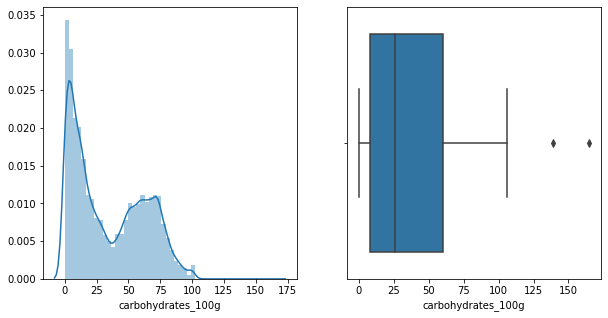

In [72]:
print(df_clean.carbohydrates_100g.describe())

#outliers
carbohydrates_100g=df_clean['carbohydrates_100g'].to_numpy()
Q1 = np.percentile(carbohydrates_100g, 25, axis=0)
Q3 = np.percentile(carbohydrates_100g, 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

boxplot_filter = (carbohydrates_100g < lower_bound) | (carbohydrates_100g > upper_bound)
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())
percentage_outliers=boxplot_filter.sum(axis=0)* 100 / len(additives_n)
print("% of outliers:", round(percentage_outliers, 3))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.distplot(df_clean.carbohydrates_100g, ax=ax1)
sns.boxplot(df_clean.carbohydrates_100g, ax=ax2);

_______________
<b>sugars_100g<b>

count    175388.000000
mean         14.792416
std          19.344396
min         -17.860000
25%           1.410000
50%           5.100000
75%          23.000000
max         104.000000
Name: sugars_100g, dtype: float64
Total number of outliers detected: 9647
% of outliers: 5.5


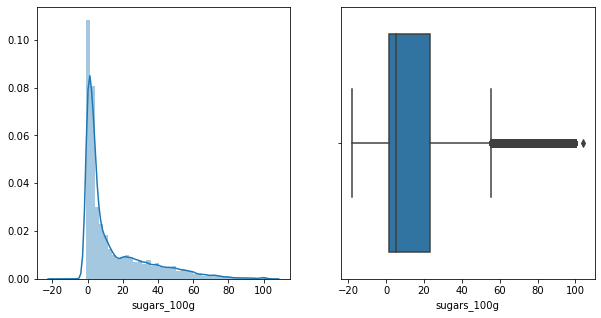

In [73]:
print(df_clean.sugars_100g.describe())

#outliers
sugars_100g=df_clean['sugars_100g'].to_numpy()
Q1 = np.percentile(sugars_100g, 25, axis=0)
Q3 = np.percentile(sugars_100g, 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

boxplot_filter = (sugars_100g < lower_bound) | (sugars_100g > upper_bound)
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())
percentage_outliers=boxplot_filter.sum(axis=0)* 100 / len(additives_n)
print("% of outliers:", round(percentage_outliers, 3))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.distplot(df_clean.sugars_100g, ax=ax1)
sns.boxplot(df_clean.sugars_100g, ax=ax2);

The minimum cannot be negative in this case. 

In [74]:
x = df_clean[df_clean['sugars_100g'] < 0] 
x.shape

(5, 26)

there are 5 rows with negative numbers. I remove those 5 from the df_clean (this will slightly change the previous plot results but let's consider that it's only 5 rows)

In [75]:
df_clean = df_clean[df_clean['sugars_100g'] >=0] 

_______________________________
<b>fiber_100g<b>

count    1.753830e+05
mean     4.836196e+05
std      2.025327e+08
min      0.000000e+00
25%      0.000000e+00
50%      1.600000e+00
75%      3.600000e+00
max      8.481815e+10
Name: fiber_100g, dtype: float64
Total number of outliers detected: 12509
% of outliers: 7.132


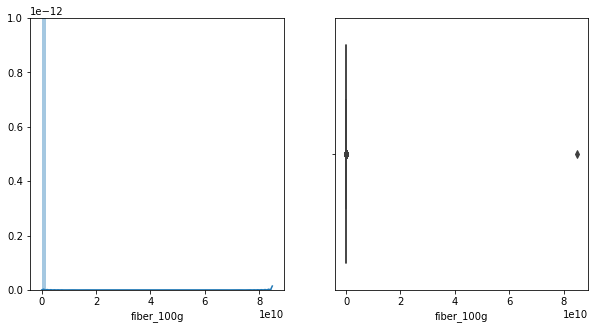

In [76]:
print(df_clean.fiber_100g.describe())

#outliers
fiber_100g=df_clean['fiber_100g'].to_numpy()
Q1 = np.percentile(fiber_100g, 25, axis=0)
Q3 = np.percentile(fiber_100g, 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

boxplot_filter = (fiber_100g < lower_bound) | (fiber_100g > upper_bound)
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())
percentage_outliers=boxplot_filter.sum(axis=0)* 100 / len(additives_n)
print("% of outliers:", round(percentage_outliers, 3))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.distplot(df_clean.fiber_100g, ax=ax1)
sns.boxplot(df_clean.fiber_100g, ax=ax2);

Here there is an extreme outlier that is affecting the plot

In [77]:
fiber_100g.max()

84818150000.0

I plot the filtered graph using the Q3 upper bound

count    126925.000000
mean          0.993776
std           1.135499
min           0.000000
25%           0.000000
50%           0.500000
75%           1.900000
max           3.570000
Name: fiber_100g, dtype: float64
Total number of outliers detected: 0
% of outliers: 0.0


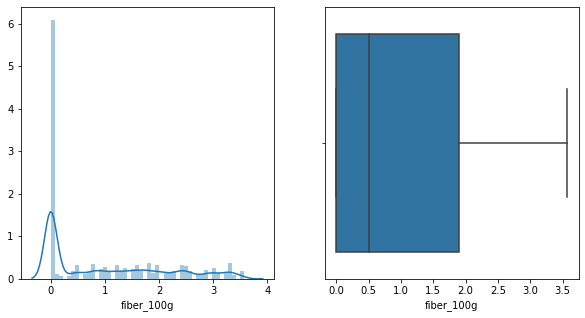

In [78]:
#filter the fiber_100g variable
fiber_100g_filter = df_clean[df_clean.fiber_100g < Q3] #important, Q3 is subscribed by every plot.
print(fiber_100g_filter.fiber_100g.describe())

#outliers
fiber_100g=fiber_100g_filter['fiber_100g'].to_numpy()
Q1 = np.percentile(fiber_100g, 25, axis=0)
Q3 = np.percentile(fiber_100g, 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

boxplot_filter = (fiber_100g < lower_bound) | (fiber_100g > upper_bound)
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())
percentage_outliers=boxplot_filter.sum(axis=0)* 100 / len(additives_n)
print("% of outliers:", round(percentage_outliers, 3))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.distplot(fiber_100g_filter.fiber_100g, ax=ax1)
sns.boxplot(fiber_100g_filter.fiber_100g, ax=ax2);

Important: I don't intend to use this variable for the next analysis. I will leave those outliers in the df_clean (even because they are a lot and may affect the other variables)

_______________________________________
<b>proteins_100g<b>

count    175383.000000
mean          7.709014
std           8.055429
min           0.000000
25%           2.000000
50%           5.700000
75%          10.710000
max         305.000000
Name: proteins_100g, dtype: float64
Total number of outliers detected: 9130
% of outliers: 5.206


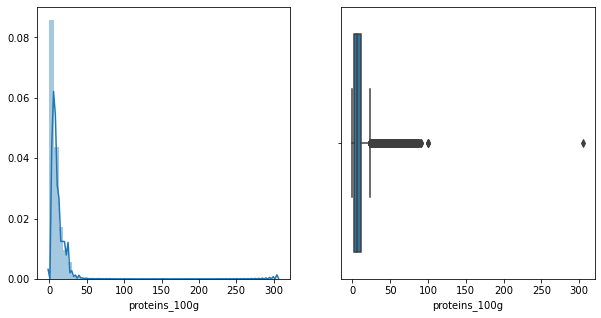

In [79]:
print(df_clean.proteins_100g.describe())

#outliers
proteins_100g=df_clean['proteins_100g'].to_numpy()
Q1 = np.percentile(proteins_100g, 25, axis=0)
Q3 = np.percentile(proteins_100g, 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

boxplot_filter = (proteins_100g < lower_bound) | (proteins_100g > upper_bound)
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())
percentage_outliers=boxplot_filter.sum(axis=0)* 100 / len(additives_n)
print("% of outliers:", round(percentage_outliers, 3))


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.distplot(df_clean.proteins_100g, ax=ax1)
sns.boxplot(df_clean.proteins_100g, ax=ax2);

Here there is probably 1 extreme outlier.

In [80]:
x =df_clean[df_clean['proteins_100g'] > 150]#150 is based on visual inspection
x.shape

(1, 26)

I remove the outlier from the df_clean

In [81]:
df_clean=df_clean[df_clean['proteins_100g']<150]
df_clean.shape

(175382, 26)

count    175382.000000
mean          7.707319
std           8.024112
min           0.000000
25%           2.000000
50%           5.700000
75%          10.710000
max         100.000000
Name: proteins_100g, dtype: float64
Total number of outliers detected: 9129
% of outliers: 5.205


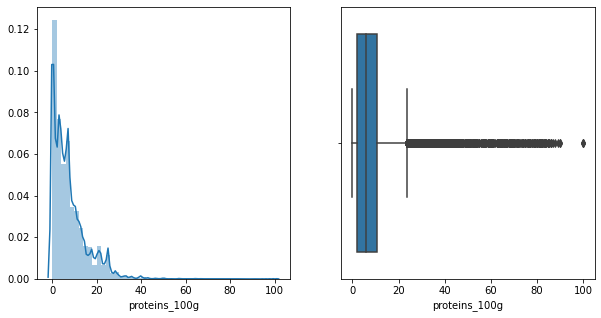

In [82]:
#I check again the results
print(df_clean.proteins_100g.describe())

#outliers
proteins_100g=df_clean['proteins_100g'].to_numpy()
Q1 = np.percentile(proteins_100g, 25, axis=0)
Q3 = np.percentile(proteins_100g, 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

boxplot_filter = (proteins_100g < lower_bound) | (proteins_100g > upper_bound)
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())
percentage_outliers=boxplot_filter.sum(axis=0)* 100 / len(additives_n)
print("% of outliers:", round(percentage_outliers, 3))


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.distplot(df_clean.proteins_100g, ax=ax1)
sns.boxplot(df_clean.proteins_100g, ax=ax2);

_____________________________
<b>salt_100g<b>

count    175382.000000
mean          1.353624
std          12.837141
min           0.000000
25%           0.100000
50%           0.640080
75%           1.330960
max        2452.413180
Name: salt_100g, dtype: float64
Total number of outliers detected: 9403
% of outliers: 5.361


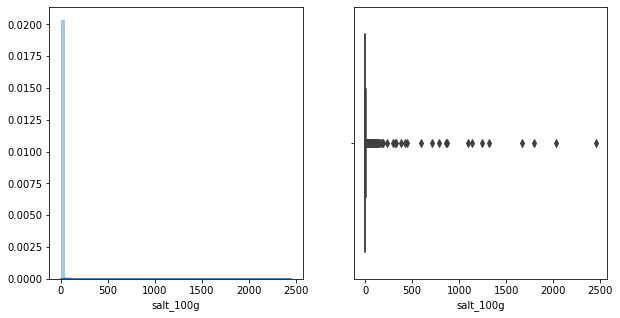

In [83]:
print(df_clean.salt_100g .describe())

#outliers
salt_100g=df_clean['salt_100g'].to_numpy()
Q1 = np.percentile(salt_100g, 25, axis=0)
Q3 = np.percentile(salt_100g, 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

boxplot_filter = (salt_100g < lower_bound) | (salt_100g > upper_bound)
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())
percentage_outliers=boxplot_filter.sum(axis=0)* 100 / len(additives_n)
print("% of outliers:", round(percentage_outliers, 3))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.distplot(df_clean.salt_100g, ax=ax1)
sns.boxplot(df_clean.salt_100g, ax=ax2);

There are several outliers. Since I'm not planning to use this variable I will not remove those from df_clean but here below I will check the graph without outliers

count    131526.000000
mean          0.436618
std           0.418239
min           0.000000
25%           0.043180
50%           0.287020
75%           0.800000
max           1.330000
Name: salt_100g, dtype: float64
Total number of outliers detected: 0
% of outliers: 0.0


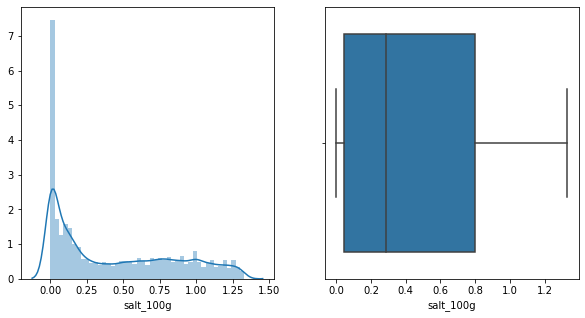

In [84]:
salt_100g_filter=df_clean[df_clean['salt_100g']<Q3] #important, Q3 is subscribed by every plot.
print(salt_100g_filter.salt_100g.describe())

#outliers
salt_100g=salt_100g_filter['salt_100g'].to_numpy()
Q1 = np.percentile(salt_100g, 25, axis=0)
Q3 = np.percentile(salt_100g, 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

boxplot_filter = (salt_100g < lower_bound) | (salt_100g > upper_bound)
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())
percentage_outliers=boxplot_filter.sum(axis=0)* 100 / len(additives_n)
print("% of outliers:", round(percentage_outliers, 3))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.distplot(salt_100g_filter.salt_100g, ax=ax1)
sns.boxplot(salt_100g_filter.salt_100g, ax=ax2);

____________________
<b>sodium_100g<b>

count    175382.000000
mean          0.532923
std           5.053992
min           0.000000
25%           0.039370
50%           0.252000
75%           0.524000
max         965.517000
Name: sodium_100g, dtype: float64
Total number of outliers detected: 9403
% of outliers: 5.361


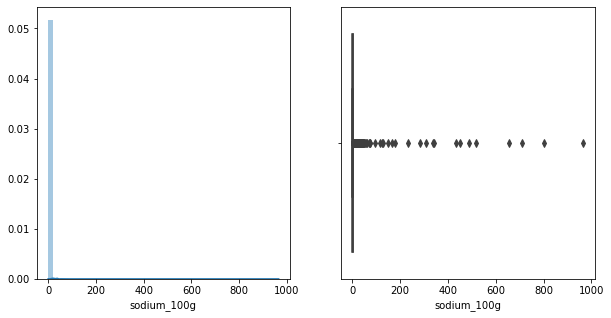

In [85]:
print(df_clean.sodium_100g .describe())

#outliers
sodium_100g=df_clean['sodium_100g'].to_numpy()
Q1 = np.percentile(sodium_100g, 25, axis=0)
Q3 = np.percentile(sodium_100g, 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

boxplot_filter = (sodium_100g < lower_bound) | (sodium_100g > upper_bound)
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())
percentage_outliers=boxplot_filter.sum(axis=0)* 100 / len(additives_n)
print("% of outliers:", round(percentage_outliers, 3))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.distplot(df_clean.sodium_100g, ax=ax1)
sns.boxplot(df_clean.sodium_100g, ax=ax2);

There are several outliers. Since I'm not planning to use this variable I will not remove those from df_clean but here below I will check the graph without outliers

count    131521.000000
mean          0.171883
std           0.164650
min           0.000000
25%           0.017000
50%           0.113000
75%           0.314961
max           0.523622
Name: sodium_100g, dtype: float64
Total number of outliers detected: 0
% of outliers: 0.0


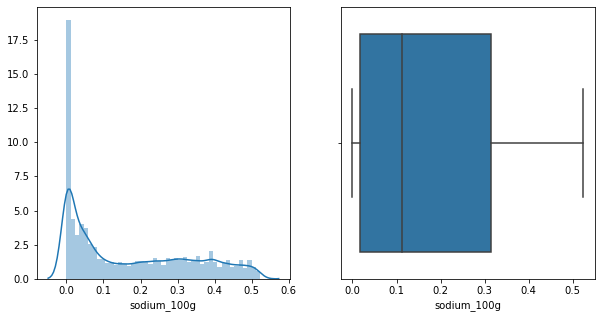

In [86]:
sodium_100g_filter=df_clean[df_clean['sodium_100g']<Q3]#important, Q3 is subscribed by every plot.
print(sodium_100g_filter.sodium_100g.describe())

#outliers
sodium_100g=sodium_100g_filter['sodium_100g'].to_numpy()
Q1 = np.percentile(sodium_100g, 25, axis=0)
Q3 = np.percentile(sodium_100g, 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

boxplot_filter = (sodium_100g < lower_bound) | (sodium_100g > upper_bound)
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())
percentage_outliers=boxplot_filter.sum(axis=0)* 100 / len(additives_n)
print("% of outliers:", round(percentage_outliers, 3))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.distplot(sodium_100g_filter.sodium_100g, ax=ax1)
sns.boxplot(sodium_100g_filter.sodium_100g, ax=ax2);

_______________________
<b>nutrition-score-fr_100g<b>

count    175382.000000
mean          8.663050
std           9.038428
min         -15.000000
25%           1.000000
50%           9.000000
75%          16.000000
max          40.000000
Name: nutrition_score_fr_100g, dtype: float64
Total number of outliers detected: 3
% of outliers: 0.002


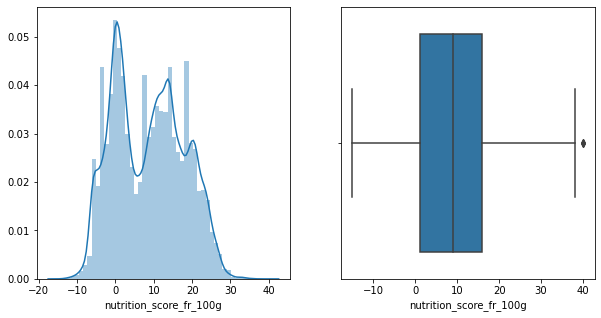

In [87]:
#this column has to be renamed first replacing '-' with '_'
df_clean.rename(columns = {'nutrition-score-fr_100g':'nutrition_score_fr_100g'}, inplace = True)

print(df_clean.nutrition_score_fr_100g.describe())

#outliers
nutrition_score_fr_100g=df_clean['nutrition_score_fr_100g'].to_numpy()
Q1 = np.percentile(nutrition_score_fr_100g, 25, axis=0)
Q3 = np.percentile(nutrition_score_fr_100g, 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

boxplot_filter = (nutrition_score_fr_100g < lower_bound) | (nutrition_score_fr_100g > upper_bound)
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())
percentage_outliers=boxplot_filter.sum(axis=0)* 100 / len(additives_n)
print("% of outliers:", round(percentage_outliers, 3))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.distplot(df_clean.nutrition_score_fr_100g, ax=ax1)
sns.boxplot(df_clean.nutrition_score_fr_100g, ax=ax2);

___________________________
<b>nutrition-score-uk_100g<b>

count    175382.000000
mean          8.516900
std           9.120165
min         -15.000000
25%           1.000000
50%           9.000000
75%          16.000000
max          40.000000
Name: nutrition_score_uk_100g, dtype: float64
Total number of outliers detected: 3
% of outliers: 0.002


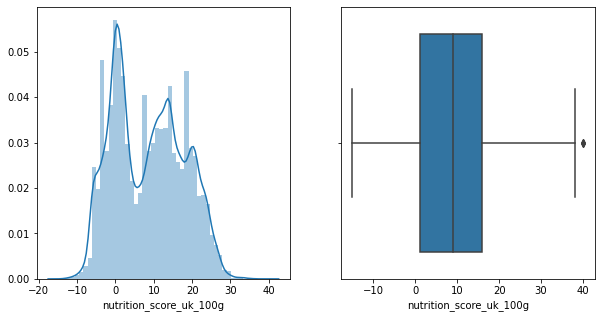

In [88]:
#this column has to be renamed first replacing '-' with '_'
df_clean.rename(columns = {'nutrition-score-uk_100g':'nutrition_score_uk_100g'}, inplace = True)

print(df_clean.nutrition_score_uk_100g.describe())

#outliers
nutrition_score_uk_100g=df_clean['nutrition_score_uk_100g'].to_numpy()
Q1 = np.percentile(nutrition_score_uk_100g, 25, axis=0)
Q3 = np.percentile(nutrition_score_uk_100g, 75, axis=0)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

boxplot_filter = (nutrition_score_uk_100g < lower_bound) | (nutrition_score_uk_100g > upper_bound)
print("Total number of outliers detected:", boxplot_filter.sum(axis=0).sum())
percentage_outliers=boxplot_filter.sum(axis=0)* 100 / len(additives_n)
print("% of outliers:", round(percentage_outliers, 3))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.distplot(df_clean.nutrition_score_uk_100g, ax=ax1)
sns.boxplot(df_clean.nutrition_score_uk_100g, ax=ax2);

_____________
<b>Summary df_clean<b>

In [89]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175382 entries, 2 to 356022
Data columns (total 26 columns):
 #   Column                                   Non-Null Count   Dtype          
---  ------                                   --------------   -----          
 0   code                                     175382 non-null  object         
 1   url                                      175382 non-null  object         
 2   creator                                  175382 non-null  object         
 3   created_datetime                         175382 non-null  datetime64[ns] 
 4   last_modified_datetime                   175382 non-null  datetime64[ns] 
 5   product_name                             175382 non-null  object         
 6   brands_tags                              175382 non-null  object         
 7   countries_en                             175382 non-null  object         
 8   ingredients_text                         175382 non-null  object         
 9   serving_size   

In [90]:
df_clean.describe()

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,delta_time
count,175382.000000,175382.000000,175382.000000,175382.000000,175382.000000,175382.000000,175382.000000,175382.000000,1.753820e+05,175382.000000,175382.000000,175382.000000,175382.000000,175382.000000,175382
mean,1.913560,0.021638,0.055450,1184.746568,12.977443,4.614597,34.277726,14.793000,4.836224e+05,7.707319,1.353624,0.532923,8.663050,8.516900,94 days 11:38:50.368293
std,2.536565,0.147369,0.268841,761.012781,15.802360,7.081170,28.224848,19.344381,2.025332e+08,8.024112,12.837141,5.053992,9.038428,9.120165,282 days 17:47:43.210953
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,-15.000000,-15.000000,0 days 00:00:00
25%,0.000000,0.000000,0.000000,454.000000,0.830000,0.000000,7.860000,1.410000,0.000000e+00,2.000000,0.100000,0.039370,1.000000,1.000000,0 days 00:00:00
50%,1.000000,0.000000,0.000000,1206.000000,6.900000,1.600000,26.000000,5.100000,1.600000e+00,5.700000,0.640080,0.252000,9.000000,9.000000,0 days 00:00:00
75%,3.000000,0.000000,0.000000,1736.000000,21.050000,6.670000,60.000000,23.000000,3.600000e+00,10.710000,1.330960,0.524000,16.000000,16.000000,0 days 00:00:12
max,30.000000,2.000000,6.000000,14644.000000,100.000000,100.000000,165.000000,104.000000,8.481815e+10,100.000000,2452.413180,965.517000,40.000000,40.000000,2015 days 05:45:37


____________________
<b><h2>2. In-depth analysis</h2><b>

In this section I will try to answer 3 questions:

1- whether the amount of sugar is bigger in USA compared to the rest of the world products.

2- if the nutrition grade related to the zone (USA or World)

3- If there are more products containing palm oil in USA or the rest of the world

In [91]:
#first I filter the df_clean based on the 4 columns I need
df_clean_analysis=df_clean.filter(items=['countries_en', 'sugars_100g', 'nutrition_grade_fr', 'ingredients_from_palm_oil_n'])

In [92]:
#flag the variables based on 'countries_en' ('USA', 'WORLD') and ingredients_from_palm_oil_n ('YES', 'NO')
df_clean_analysis['USAorWORLD'] = np.where(df_clean_analysis['countries_en'].str.contains('united states'), 'USA', 'WORLD')#consider that if a food is produced by USA + another country it will be flagged as 'USA'
df_clean_analysis['Presence_of_palm_oil'] = np.where(df_clean_analysis['ingredients_from_palm_oil_n']>0,'YES', 'NO')

In [93]:
df_clean_analysis

,countries_en,sugars_100g,nutrition_grade_fr,ingredients_from_palm_oil_n,USAorWORLD,Presence_of_palm_oil
2,united states,17.86,b,0.0,USA,NO
3,united states,3.57,d,0.0,USA,NO
7,united states,15.62,c,0.0,USA,NO
12,united states,3.33,d,0.0,USA,NO
15,united states,21.82,b,0.0,USA,NO
...,...,...,...,...,...,...
355979,france,12.00,d,0.0,WORLD,NO
355980,france,0.00,b,0.0,WORLD,NO
355981,france,27.00,d,0.0,WORLD,NO
355985,united states,2.35,a,0.0,USA,NO


__________
<h4>2.1. Amount of sugar USA vs World</h4>

In this section, I will analyze whether the amount of sugar is bigger in USA products compared with the rest of the world.
For this analysis, I will use a 2 sample t-test.

In [94]:
import scipy.stats as stats

In [95]:
#t.test
USA = df_clean_analysis[df_clean_analysis['USAorWORLD']=='USA']
WORLD = df_clean_analysis[df_clean_analysis['USAorWORLD']=='WORLD']

sugar_result= stats.ttest_ind(USA['sugars_100g'], WORLD['sugars_100g'])

Ttest_indResult(statistic=26.105313307469892, pvalue=6.15296928116034e-150)


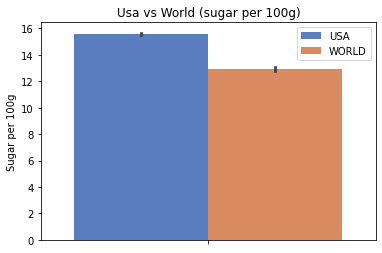

In [96]:
#print t-test
print(sugar_result)

#violin plot
df_clean_analysis['index_plot']=0 #to create the create a side-by-side violin plot I must use a further index that I will create ad-hoc ad column of '0'
sugar_plot = sns.barplot(x='index_plot', y='sugars_100g', hue='USAorWORLD', data=df_clean_analysis, palette="muted")
sugar_plot.set(xticklabels=[])
sugar_plot.set_xlabel('')
sugar_plot.set_ylabel('Sugar per 100g')
sugar_plot.set_title('Usa vs World (sugar per 100g)')
plt.gca().legend().set_title('');#remove legend title

USA products make larger use of sugar compared to the rest of the world

__________
<h4>2.2. Nutrition score USA vs World</h4>   

Here I will use a chisquare analysis to see if there is a relationship between the part of the world (USA or World) and the nutrition grade

In [97]:
#filter data
contingency_table=df_clean_analysis.filter(items=['nutrition_grade_fr', 'USAorWORLD'])

#use pd.crosstab to create a contingency table. ref https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.crosstab.html
contingency_table=pd.crosstab(contingency_table.nutrition_grade_fr, contingency_table.USAorWORLD)

In [98]:
contingency_table

USAorWORLD,USA,WORLD
nutrition_grade_fr,,
a,19722,11939
b,18848,8496
c,24904,11848
d,35124,12364
e,24222,7915


In [99]:
from scipy.stats import chi2_contingency #ref https://machinelearningmastery.com/chi-squared-test-for-machine-learning/
stat, p, dof, expected = chi2_contingency(contingency_table)
print(stat, p, dof, expected)

1796.263762580972 0.0 4 [[22172.19566432  9488.80433568]
 [19149.0009237   8194.9990763 ]
 [25737.42254051 11014.57745949]
 [33255.84244677 14232.15755323]
 [22505.5384247   9631.4615753 ]]


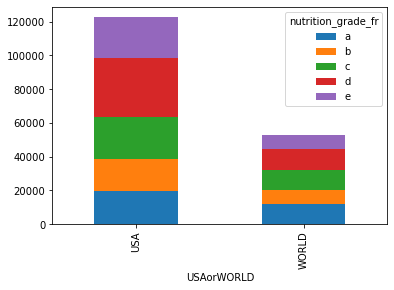

In [100]:
contingency_table.reset_index(level=0, inplace=True)#turn the index into a column to plot the data
contingency_table.set_index('nutrition_grade_fr').T.plot(kind='bar', stacked=True);

These results should be further explored with post-hoc analysis but overall I can conclude that there there is a relationship between those categorical variables.

_________
<h4>2.3. Products from Palm oil USA vs World</h4>   

In [101]:
pd.crosstab(df_clean_analysis.USAorWORLD,df_clean_analysis.Presence_of_palm_oil)

Presence_of_palm_oil,NO,YES
USAorWORLD,,
USA,122813,7
WORLD,48822,3740


In [102]:
#insuccess/success array
results = np.array([[122806, 7],[45082, 3740]])

In [103]:
chi_square, p_value, df, matrix = stats.chi2_contingency(observed=results)

In [104]:
chi_square, p_value

(9582.2071865319, 0.0)

This statistic is not necessary (due to the huge difference) but overall, compared to USA, the rest of the world uses way more products that are from palm oil

____________________
<b><h2>3. Time-series analysis</h2><b>

In [105]:
df_clean.delta_time.mean()#mean

Timedelta('94 days 11:38:50.368293')

In [106]:
#order the data frame by created_datetime
df_clean.sort_values('created_datetime', ascending = True, inplace=True)
df_clean['item']=1#create a column with 1 on each line to compute the sum of monthly items

In [107]:
#use the sum of 'item' to resample the dataframe on montly basis
df_clean_resampled_m = df_clean.resample('M', on='created_datetime').sum()

In [108]:
df_clean_resampled_m

,additives_n,ingredients_from_palm_oil_n,ingredients_that_may_be_from_palm_oil_n,energy_100g,fat_100g,saturated_fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,salt_100g,sodium_100g,nutrition_score_fr_100g,nutrition_score_uk_100g,item
created_datetime,,,,,,,,,,,,,,,
2012-02-29,9.0,1.0,0.0,8030.000,80.0000,31.8000,258.4000,134.2000,1.410000e+01,32.3000,3.599600,1.417165,67.0,67.0,5
2012-03-31,92.0,2.0,16.0,85051.000,1056.7200,347.1000,2163.2100,902.0400,1.557000e+02,478.4700,95.493412,37.594650,514.0,487.0,67
2012-04-30,180.0,3.0,20.0,98924.400,1011.5900,459.3630,2950.1700,1075.2900,2.901930e+02,722.4300,90.062388,35.454798,599.0,573.0,84
2012-05-31,411.0,12.0,49.0,230591.400,2554.9650,1138.2260,6169.1000,2626.0700,5.978700e+02,1794.4050,220.199504,86.692165,1401.0,1232.0,223
2012-06-30,1084.0,23.0,98.0,400901.470,4014.2690,1568.1230,11708.2729,5009.0950,1.157828e+03,2763.6379,339.957613,133.869313,2951.0,2075.0,479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-05-31,3667.0,155.0,226.0,2996353.530,32031.9051,11336.5601,82907.9921,36193.3613,9.322575e+03,20304.8311,2593.525970,1021.075277,19977.0,17959.0,2663
2017-06-30,4252.0,161.0,301.0,3339967.980,35793.3720,12467.4851,91100.2180,39178.4870,9.473910e+03,22867.8640,2831.614662,1114.805008,22075.0,20008.0,2974
2017-07-31,3721.0,141.0,266.0,2899810.230,30918.2526,10849.9503,79769.4806,34590.1156,8.528220e+03,19043.3432,2674.175600,1052.829246,20125.0,18265.0,2536


In [109]:
from matplotlib.dates import DateFormatter #I need it to properly format the plot. ref https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/
import matplotlib.dates as mdates
date_form = DateFormatter("%m-%Y")#create the proper date formatter

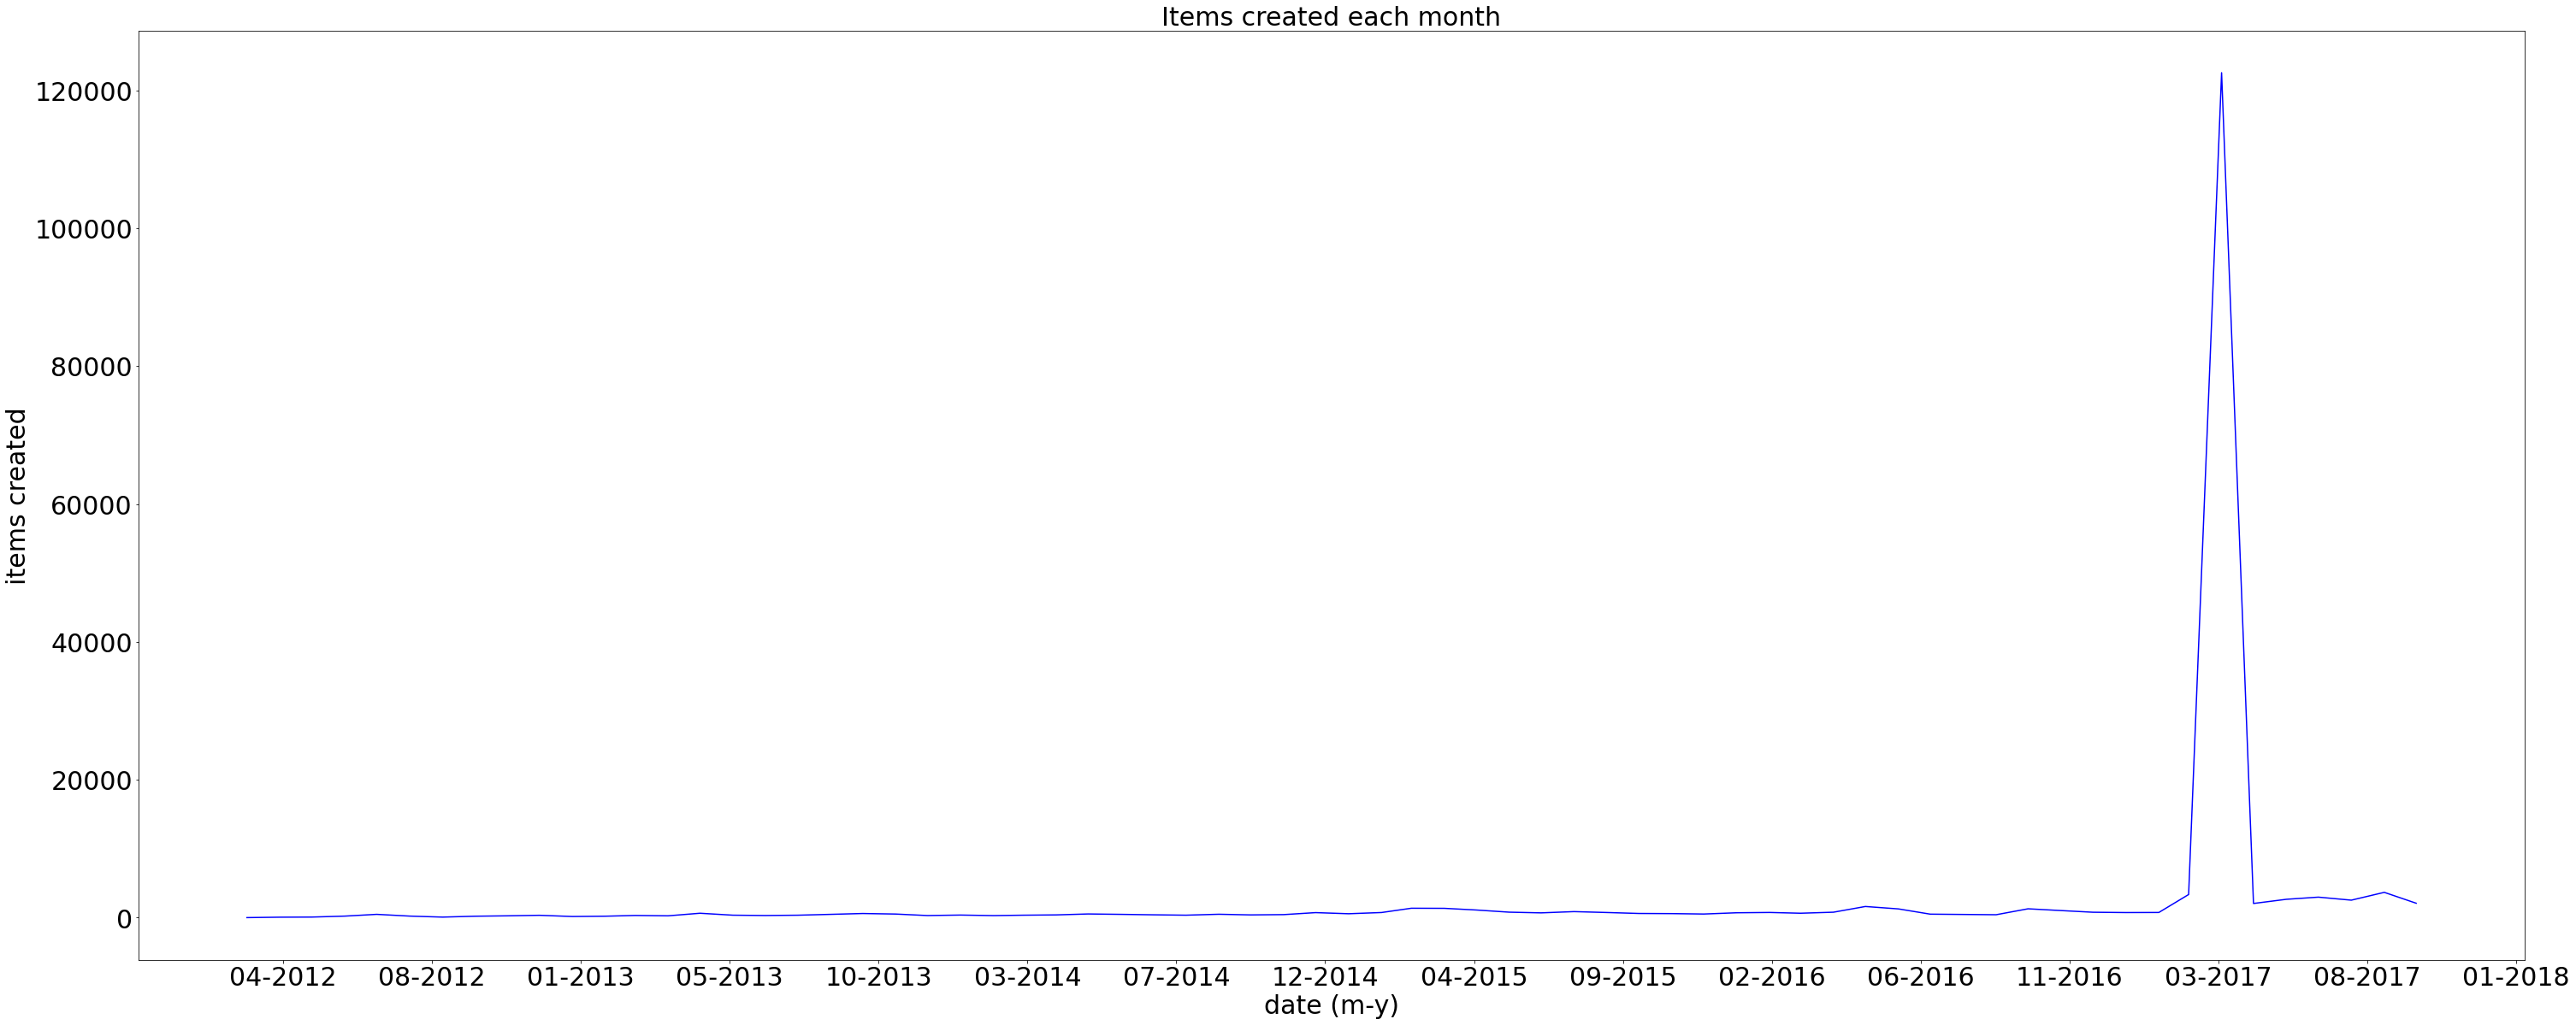

In [122]:
#solution found here, https://www.earthdatascience.org/courses/use-data-open-source-python/use-time-series-data-in-python/date-time-types-in-pandas-python/customize-dates-matplotlib-plots-python/
# Create figure and plot space
fig, ax = plt.subplots(figsize=(50, 20))

# Add x-axis and y-axis
ax.plot(df_clean_resampled_m.index.values,
       df_clean_resampled_m['item'],
       color='blue')

# Define the date format
ax.xaxis.set_major_formatter(date_form)

ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=20))#change the intervals

#axis size
plt.title('Items created each month', fontsize=30)
plt.xlabel('date (m-y)', fontsize=30)
plt.ylabel('items created', fontsize=30)
ax.tick_params(labelsize=30)
plt.show()

_____
<b><h2>4. Build a database</h2><b>

In [111]:
#I select 1000 random rows from my dataframe
df_clean_database=df_clean.sample(n=1000, random_state=1)
#I select the following columns. Code will be the primary key since it is unique for each row
df_clean_database=df_clean_database[['code', 'countries_en', 'brands_tags', 'fiber_100g', 'proteins_100g']]

In [112]:
import sqlite3

In [113]:
#connect
db = sqlite3.connect('database')
cursor = db.cursor()

#set code as primary key
query = "CREATE TABLE products (code PRIMARY KEY, countries_en TEXT, brands_tags TEXT, fiber_100g FLOAT, proteins_100g FLOAT);"
cursor.execute(query)

In [114]:
pd.read_sql_query('SELECT * FROM products;', db)

,code,countries_en,brands_tags,fiber_100g,proteins_100g


In [115]:
#fill the database
df_clean_database.to_sql(name='products', con=db, if_exists='append', index=False)

In [116]:
pd.read_sql_query('SELECT * FROM products;', db)

,code,countries_en,brands_tags,fiber_100g,proteins_100g
0,0862069000120,united states,stone-skillet-llc,3.5,8.24
1,3560070464791,france,carrefour,0.9,0.70
2,3369570176919,france,colombo,0.0,25.00
3,0855387005243,united states,gluuteny-llc,0.0,2.86
4,0070935007795,united states,umeya-inc,3.3,3.33
...,...,...,...,...,...
995,3560071003227,france,carrefour,2.1,23.00
996,0753656710327,united states,think-thin,10.0,26.00
997,0070309031289,united states,usinger-s,0.0,12.50
998,3608580004066,france,"taillefine,danone",7.1,0.40


In [117]:
#test query 
pd.read_sql_query("SELECT AVG(proteins_100g) AS 'Average proteins' FROM products;", db)

,Average proteins
0,7.772441


In [118]:
#check if the same result is reported using the dataframe
df_clean_database.proteins_100g.mean()

7.7724410000000095

_____________
<b><h2>5. Correlations with nutritional score</h2><b>

In [119]:
#I create a dataframe for the plot
df_clean_correlations=df_clean[['nutrition_score_fr_100g', 'additives_n', 'ingredients_from_palm_oil_n', 'energy_100g', 'fat_100g', 'saturated_fat_100g', 'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g']]

In [120]:
#I will use an heatmap
heat=pd.DataFrame(df_clean_correlations[df_clean_correlations.columns[:]].corr()['nutrition_score_fr_100g'][:])#create a dataframe containing the correlation coefficient
heat.sort_values('nutrition_score_fr_100g', ascending = False, inplace= True)

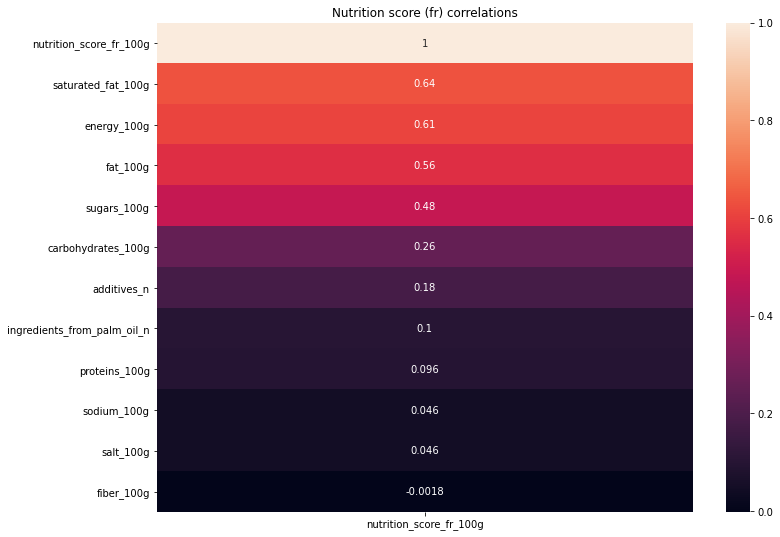

In [121]:
plt.figure(figsize=(12, 9))

#heatmap ref https://datatofish.com/correlation-matrix-pandas/
sns.heatmap(heat, annot=True).set_title('Nutrition score (fr) correlations'); #heatmap ref https://datatofish.com/correlation-matrix-pandas/

The variables with a moderate/good associated with the nutrition score are saturated fat, energy, fat, and sugars. Differently, carbohydrates, number of additives, number of ingredients from palm oil, proteins, sodium, salt, and fiber are associated with a lower nutrition grade.